# Content

[1. Setup](#Setup)

[2. Data Cleaning and Preparation](#Data-Cleaning-&-Preparation)

# Setup & Import¶

In [855]:
#import basic system functions
import os
import datetime
from collections import Counter
import itertools

import random

#import libraries for data wrangling
import pandas as pd
import numpy as np

#import libraries for plotting data
import matplotlib.pyplot as plt
import matplotlib.pyplot as mplt

%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.plotting import autocorrelation_plot, lag_plot
from scipy import signal
# If you want a style choose one
#plt.style.use('Solarize_Light2')
#plt.style.use('tableau-colorblind10')
NF_ORANGE = '#ff5a36'
NF_BLUE = '#163251'



#import libraries for time series analysis
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from pmdarima.arima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

#import libraries for statistics
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


from IPython.display import Image
from datetime import datetime
import holidays

In [ ]:
df_2= pd.read_csv("df_new_2.csv")
df_2_clean= pd.read_csv("data_2_clean.csv")

In [ ]:
df_2.drop(columns=['Unnamed: 0'],inplace=True)
df_2_clean.drop(columns=['Unnamed: 0'],inplace=True)

In [ ]:
#df= pd.read_csv("/Users/brittarover/Capstone/Meteolytics/meteolytix_Artikelgruppen_Umsatz_verschiedeneStandorte.csv")

In [ ]:
df_2_clean.head(2)

In [ ]:
df_2_clean.info()

In [ ]:
df_2.shape

## Convert to datetime

In [ ]:
df_2['Datum'] = pd.to_datetime(df_2['Datum'])
df_2_clean['Datum'] = pd.to_datetime(df_2_clean['Datum'])


In [ ]:
df_basis_2=df_2.iloc[:,1:13]
df_basis_2_clean=df_2_clean.iloc[:,1:13]
df_basis_2_dum=df_2_dum.iloc[:,1:13]

## Modify categorical features

In [ ]:
month_dummy= pd.get_dummies(df_2_clean['Monat'], prefix='M', drop_first=True)
weekday_dummy= pd.get_dummies(df_2_clean['Wochentag'], prefix='W', drop_first=True)
season_dummy=pd.get_dummies(df_2_clean['Season'], prefix='S', drop_first=True)

In [ ]:
df_2_dum = df_2_clean.drop(['Tag','Monat','Wochentag','Jahr','Season'], axis=1) 

In [ ]:
df_2_dum = pd.concat([df_2_dum,month_dummy,weekday_dummy,season_dummy], axis=1) 

In [ ]:
df_2_dum.columns

### Kieler Woche

In [ ]:
kieler_woche= pd.DataFrame({'date':pd.date_range('2019-06-22', '2019-06-30')})
kieler_woche = kieler_woche.append(pd.DataFrame({'date':pd.date_range('2018-06-16', '2018-06-24')}))
kieler_woche = kieler_woche.append(pd.DataFrame({'date':pd.date_range('2017-06-17', '2017-06-25')}))
kieler_woche = kieler_woche.append(pd.DataFrame({'date':pd.date_range('2016-06-18', '2016-06-26')}))
kieler_woche = kieler_woche.append(pd.DataFrame({'date':pd.date_range('2015-06-20', '2015-06-28')}))

In [ ]:
kieler_woche['Datum']=kieler_woche['date'].apply(lambda x: x.strftime(format = "%Y-%m-%d"))
liste_kw=kieler_woche['Datum'].tolist()

In [ ]:
#Definition of new column Kieler Woche
df_2_dum['Kieler_Woche']=df_2_dum['Datum'].apply(lambda x: 1 if x.strftime(format = "%Y-%m-%d") in liste_kw else 0)

## Timerelated Features for Salesvolumne in the past

#### Values of the previous week and year

In [ ]:
articlelist=df_basis_2_dum.columns.tolist()

In [577]:
#For multiple Columns and also Dataframes
var=['Gesamt']
numbers=[7,364]

for i in var:
    for j in numbers:
       df_2_dum["%s_%d" % (i,j)]=df_2_dum[i].shift(j)
       df_2_dum["%s_%d" % (i,j)].fillna(0)

In [ ]:
#For multiple Columns and also Dataframes
var=['Brötchen','Süsse_Brötchen','Herzhafte_Brötchen']
numbers=[7,364]

for i in var:
    for j in numbers:
       df_2_clean["%s_%d" % (i,j)]=df_2_clean[i].shift(j)
       df_2_clean["%s_%d" % (i,j)].fillna(0)

#### mean and max-Values for Weekday and Monthly Values

**Conclusions**
- `Mean and Maxvalues have no significant impact to the correlation. I need to do it for Months and Weekdays.`


In [ ]:
# Definition on weekldaybase
def Brötchen_mean(x):
    return df_2.groupby('Wochentag')['Brötchen'].mean()[x]
def Brötchen_max(x):
    return df_2.groupby('Wochentag')['Brötchen'].max()[x]


In [ ]:
#For multiple Columns and also Dataframes
var=['Süsse_Brötchen','Herzhafte_Brötchen']


for i in var:
    name=i+ "_mean"
    
    def name(x):
        return df_2.groupby('Wochentag')['%s' % (i)].mean()[x]

    df_2['%s_mean_WD' % (i)]=df_2['Wochentag'].apply(lambda x:  name(x))
                                   

In [ ]:
#For multiple Columns and also Dataframes
var=['Süsse_Brötchen','Herzhafte_Brötchen']


for i in var:
    name=i+ "_max"
    
    def name(x):
        return df_2.groupby('Wochentag')['%s' % (i)].mean()[x]

    df_2['%s_max_WD' % (i)]=df_2['Wochentag'].apply(lambda x:  name(x))

In [ ]:
def Brötchen_mean_M(x):
    return df_2.groupby('Monat')['Brötchen'].mean()[x]
def Brötchen_max_M(x):
    return df_2.groupby('Monat')['Brötchen'].max()[x]


In [ ]:
df_2['Brötchen_mean_M']=df_2['Monat'].apply(lambda x:  Brötchen_mean_M(x))
df_2['Brötchen_max_M']=df_2['Monat'].apply(lambda x:  Brötchen_max_M(x))


In [ ]:
#For multiple Columns and also Dataframes
var=['Süsse_Brötchen','Herzhafte_Brötchen']

for i in var:
    name=i+ "_mean"
    
    def name(x):
        return df_2.groupby('Monat')['%s' % (i)].mean()[x]

    df_2['%s_mean_M' % (i)]=df_2['Monat'].apply(lambda x:  name(x))

In [ ]:
#For multiple Columns and also Dataframes
var=['Süsse_Brötchen','Herzhafte_Brötchen']


for i in var:
    name=i+ "_max"
    
    def name(x):
        return df_2.groupby('Monat')['%s' % (i)].mean()[x]

    df_2['%s_max_M' % (i)]=df_2['Monat'].apply(lambda x:  name(x))
                                   

## Distribution

In [ ]:
# Valuation of agg.Values
df_2.describe().T

## Correlations

In [ ]:
# correlation für Brötchen
basis=num_df.corr(method='pearson')['Brötchen'].sort_values(axis=0, ascending=False)
basis.plot(kind='bar',figsize=(10,8),title='Korrelation nach Pearson für Brötchen')

In [ ]:
#First we create a new DataFrame with only numerical features
numerics = ['int64', 'float64']

num_df = df_2.select_dtypes(include=numerics)

#Korrelationsanalyse
mask = np.triu( num_df.corr())
plt.figure(figsize=(30,18))
plt.title('Correlation of variables')
ax=sns.heatmap(num_df.corr(),vmax=1.0,annot=True,mask=mask,cmap='coolwarm')
plt.savefig('correlogram_simple.png')
ax.set_ylim((0,40))
plt.show

In [ ]:
df_2.to_csv("df_new_2.csv")

# Checks Timeseries & Setup Modelling

In [578]:
df_newmodel_2 = df_2.set_index('Datum')
df_newmodel_2_dum=df_2_dum.set_index('Datum')

In [ ]:
#df_new_1_index=df_newmodel_1.set_index('Datum')
#df_new_2_index=df_newmodel_2.set_index('Datum')
#df_new_3_index=df_newmodel_1.set_index('Datum')

## Metrics

**Conclusions**
- `I choose MAE and MAPE as Performance Measures for my project.`

I would analyse the results from the different models via the two different metrics mean absolute error **MAE** which is available via Sklearn.metrics and via the metrics mean absolute percentage error called **MAPE**.

There is no inbuilt function in sci-kit learn, so i define a custom function to calculate this measure. I adjusted the commom measure in the way that i do not consider all closed days of a Filiale.


In [355]:
#calculate mean absolute forecast error which only take actual values unequal to zero in consideration
def mean_absolute_percentage_error_WZ(actual, predicted): 
    
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100


In [356]:
#calculate mean absolute percentage forecast error
def mean_absolute_percentage_error(actual, predicted): 
    
    nz_1=(actual==0)
    actual_nz=actual[nz_1==0]
    
    difference_nz=actual-predicted
    difference_nz.dropna()
    return np.mean(np.abs((difference_nz) / actual_nz)) * 100

In [357]:
#calculate mean absolute percentage forecast error
def mean_absolute_percentage_error_modify(actual, predicted): 
    
    nz_1=(actual==0)
    actual_nz=actual[nz_1==0]
    
    difference_nz=actual-predicted
    difference_nz.dropna()
    return np.mean(np.abs((difference_nz))) 

In [856]:
from sklearn.metrics import make_scorer
def mae(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    distance_mean = distance.mean()
    score = np.sqrt(distance_mean)
    return score

In [857]:
mae_score = make_scorer(mae, greater_is_better = False)

In [ ]:
def regression_results(y_true, y_pred):
# Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MAPE', round(mean_absolute_percentage_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

## Test-/Train-Split

Split into train and test datasets to build the model on the training dataset and forecast using the test dataset. I decide to use the first 4 years for training and the period since 01.01.2019 for testing. 

In [579]:
# use past 4 years data to forecast the next 15 months until corona

start_train='01.01.2016'
end_train = '31.12.2018'
start_test='01.01.2019'
corona='15.03.2020'

In [580]:
# Basismodel
train_basis_2 = df_newmodel_2_dum[:end_train].copy()
test_basis_2 = df_newmodel_2_dum[end_train:corona].copy()

In [581]:
train_2 = df_newmodel_2_dum[start_train:end_train].copy()
test_2 = df_newmodel_2_dum[start_test:corona].copy()

## Baseline Model

The moving average value can also be used directly to make predictions as a naive model and baseline for further 
on analysis. The fit would has been better if trend and seasonality components of the time series have already been removed or adjusted for.

In [364]:
# moving average smoothing as a forecast model
from math import sqrt
from numpy import mean
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

In [371]:
df_results_Baseline= pd.read_csv("df_results_Baseline")
df_results_Baseline.drop(columns=['Unnamed: 0'],inplace=True)
df_results_Baseline

,Model,Label,MAE_BASELINE
0,BASELINE,Weizenbrot,21.810966
1,BASELINE,Mischbrot,14.696344
2,BASELINE,Vollkornbrot,17.744443
3,BASELINE,Stangenbrote,13.188681
4,BASELINE,Spezialbrot,16.508831
5,BASELINE,Brötchen,77.563061
6,BASELINE,Süsse_Brötchen,32.109803
7,BASELINE,Herzhafte_Brötchen,18.289108
8,BASELINE,KonditoreiBlech,34.783809
9,BASELINE,Stückgebäck,36.841229


# Random Forest

In [ ]:
start_train='01.01.2016'
end_train = '31.12.2018'
start_test='01.01.2019'
corona='15.03.2020'

In [582]:
# Basismodel
train_2 = df_2_dum[365:1461]

In [583]:
test_2 = df_2_dum[1462:1901]

In [584]:
train_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 365 to 1460
Data columns (total 73 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Datum                   1096 non-null   datetime64[ns]
 1   Weizenbrot              1096 non-null   float64       
 2   Mischbrot               1096 non-null   float64       
 3   Vollkornbrot            1096 non-null   float64       
 4   Stangenbrote            1096 non-null   float64       
 5   Spezialbrot             1096 non-null   float64       
 6   Brötchen                1096 non-null   float64       
 7   Süsse_Brötchen          1096 non-null   float64       
 8   Herzhafte_Brötchen      1096 non-null   float64       
 9   KonditoreiBlech         1096 non-null   float64       
 10  Stückgebäck             1096 non-null   float64       
 11  Blechkuchen             1096 non-null   float64       
 12  Weihnachtsartikel       1096 non-null   float6

In [ ]:
for i in train_2.iloc[:,1:13].columns:
     train_2[i]=train_2[i].astype(int)

In [ ]:
for i in test_2.iloc[:,1:13].columns:
     test_2[i]=test_2[i].astype(int)

In [ ]:
y_train_2_1=train_2['Weizenbrot']
y_train_2_2=train_2['Mischbrot']
y_train_2_3=train_2['Vollkornbrot']
y_train_2_4=train_2['Spezialbrot']
y_train_2_5=train_2['Stangenbrote']
y_train_2_6=train_2['Brötchen']
y_train_2_7=train_2['Süsse_Brötchen']
y_train_2_8=train_2['Herzhafte_Brötchen']
y_train_2_9=train_2['KonditoreiBlech']
y_train_2_10=train_2['Stückgebäck']
y_train_2_11=train_2['Blechkuchen']
y_train_2_12=train_2['Weihnachtsartikel']

In [ ]:
y_test_2_1=test_2['Weizenbrot']
y_test_2_2=test_2['Mischbrot']
y_test_2_3=test_2['Vollkornbrot']
y_test_2_4=test_2['Spezialbrot']
y_test_2_5=test_2['Stangenbrote']
y_test_2_6=test_2['Brötchen']
y_test_2_7=test_2['Süsse_Brötchen']
y_test_2_8=test_2['Herzhafte_Brötchen']
y_test_2_9=test_2['KonditoreiBlech']
y_test_2_10=test_2['Stückgebäck']
y_test_2_11=test_2['Blechkuchen']
y_test_2_12=test_2['Weihnachtsartikel']

In [ ]:
print(X_train_2_6.shape, X_test_2_6.shape) 

In [ ]:
y_train_2_6.head()

## Basismodel

In [387]:
df_results_Random_Forest = pd.DataFrame( 
                  columns=['Model', 'Label','MAE','MAPE'])

In [877]:
df_results_Random_Forest.to_csv("df_results_Random_Forest.csv")

In [876]:
df_results_Random_Forest.sort_values(['Label','MAPE']) 

,Model,Label,MAE,MAPE
11,Random_Forest-Basis,Blechkuchen,26.5626,30.3632
23,Random_Forest-Basis,Blechkuchen,26.2096,30.5732
18,Random_Forest-Advanced,Brötchen,56.0729,13.5356
42,Random_Forest-Advanced_inclGesamt,Brötchen,56.7836,13.682
54,Random_Forest-Advanced_Closedrepl,Brötchen,67.5034,14.099
30,Random_Forest-Advanced_year,Brötchen,59.9043,14.7575
6,Random_Forest-Basis,Brötchen,61.8269,15.1678
8,Random_Forest-Basis,Herzhafte_Brötchen,30.8497,26.9775
20,Random_Forest-Advanced,Herzhafte_Brötchen,30.8497,26.9775
56,Random_Forest-Advanced,Herzhafte_Brötchen,30.8497,26.9775


### Weizenbrot

In [ ]:
X_train_2_1=train_2.iloc[:,np.r_[14,16,17,19,26:46]]
X_test_2_1=test_2.iloc[:,np.r_[14,16,17,19,26:46]]

In [ ]:
X_train=X_train_2_1
X_test=X_test_2_1
y_train=y_train_2_1

In [ ]:
# Step 1: Make an instance of the Model
forest = RandomForestClassifier(random_state = 0)

In [ ]:
# Step 2: Train the model on the data
forest.fit(X_train,y_train)

In [ ]:
# Step 3: predict the response for test data
y_pred_rf_2_1= forest.predict(X_test)

n_nodes = []
max_depths = []
n_features=[]

for ind_tree in forest.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

In [388]:
train_rf_predictions = forest.predict(X_train)
train_rf_probs = forest.predict_proba(X_train)[:, 1]

rf_predictions = forest.predict(X_test)
rf_probs = forest.predict_proba(X_test)[:, 1]

MAE_1 = mean_absolute_error(y_test_2_1,y_pred_rf_2_1)
MAE_mod=mean_absolute_percentage_error_modify(y_test_2_1,y_pred_rf_2_1)
MAPE_1=mean_absolute_percentage_error(y_test_2_1,y_pred_rf_2_1)
print(f'Der MAE für Weizenbrot beträgt:{MAE_1}')
#print(f'Der MAE_mod für Weizenbrot beträgt:{MAE_mod}')
print(f'Der MAPE für Weizenbrot beträgt:{MAPE_1}')
df_results_Random_Forest.loc['1',:] = ['Random_Forest-Basis','Weizenbrot',MAE_1,MAPE_1]

Der MAE für Weizenbrot beträgt:11.580865603644646
Der MAPE für Weizenbrot beträgt:20.43113632145929


### Mischbrot

In [ ]:
X_train_2_2=train_2.iloc[:,np.r_[14,16,17,19,26:46]]
X_test_2_2=test_2.iloc[:,np.r_[14,16,17,19,26:46]]

In [ ]:
X_train=X_train_2_2
X_test=X_test_2_2
y_train=y_train_2_2

In [ ]:
# Step 1: Make an instance of the Model
forest = RandomForestClassifier(random_state = 0)

In [ ]:
# Step 2: Train the model on the data
forest.fit(X_train,y_train)

In [ ]:
# Step 3: predict the response for test data
y_pred_rf_2_2= forest.predict(X_test)

n_nodes = []
max_depths = []
n_features=[]

for ind_tree in forest.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

In [389]:
train_rf_predictions = forest.predict(X_train)
train_rf_probs = forest.predict_proba(X_train)[:, 1]

rf_predictions = forest.predict(X_test)
rf_probs = forest.predict_proba(X_test)[:, 1]

MAE_2 = mean_absolute_error(y_test_2_2,y_pred_rf_2_2)
MAE_mod=mean_absolute_percentage_error_modify(y_test_2_2,y_pred_rf_2_2)
MAPE_2=mean_absolute_percentage_error(y_test_2_2,y_pred_rf_2_2)
print(f'Der MAE für Mischbrot beträgt:{MAE_2}')
#print(f'Der MAE_mod für Weizenbrot beträgt:{MAE_mod}')
print(f'Der MAPE für Mischbrot beträgt:{MAPE_2}')
df_results_Random_Forest.loc['2',:] = ['Random_Forest-Basis','Mischbrot',MAE_2,MAPE_2]

Der MAE für Mischbrot beträgt:14.054669703872438
Der MAPE für Mischbrot beträgt:20.89437760632814


### Vollkornbrot

In [ ]:
X_train_2_3=train_2.iloc[:,np.r_[14,16,17,19,26:46]]
X_test_2_3=test_2.iloc[:,np.r_[14,16,17,19,26:46]]

In [ ]:
X_train=X_train_2_3
X_test=X_test_2_3
y_train=y_train_2_3

In [ ]:
# Step 1: Make an instance of the Model
forest = RandomForestClassifier(random_state = 0)

In [ ]:
# Step 2: Train the model on the data
forest.fit(X_train,y_train)

In [ ]:
# Step 3: predict the response for test data
y_pred_rf_2_3 = forest.predict(X_test)

n_nodes = []
max_depths = []
n_features=[]

for ind_tree in forest.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')


In [390]:
train_rf_predictions = forest.predict(X_train)
train_rf_probs = forest.predict_proba(X_train)[:, 1]

rf_predictions = forest.predict(X_test)
rf_probs = forest.predict_proba(X_test)[:, 1]

MAE_3 = mean_absolute_error(y_test_2_3,y_pred_rf_2_3)
MAE_mod=mean_absolute_percentage_error_modify(y_test_2_3,y_pred_rf_2_3)
MAPE_3=mean_absolute_percentage_error(y_test_2_3,y_pred_rf_2_3)
print(f'Der MAE für Vollkornbrot beträgt:{MAE_3}')
#print(f'Der MAE_mod für Vollkornbrot beträgt:{MAE_mod}')
print(f'Der MAPE für Vollkornbrot beträgt:{MAPE_3}')
df_results_Random_Forest.loc['3',:] = ['Random_Forest-Basis','Vollkornbrot',MAE_3,MAPE_3]

Der MAE für Vollkornbrot beträgt:24.59908883826879
Der MAPE für Vollkornbrot beträgt:19.608865755704617


### Spezialbrot

In [ ]:
X_train_2_4=train_2.iloc[:,np.r_[14,27:43]]
X_test_2_4=test_2.iloc[:,np.r_[14,27:43]]

In [380]:
X_train_2_4=train_2.iloc[:,np.r_[14:43]]
X_test_2_4=test_2.iloc[:,np.r_[14:43]]

In [381]:
X_train=X_train_2_4
X_test=X_test_2_4
y_train=y_train_2_4

In [382]:
# Step 1: Make an instance of the Model
forest = RandomForestClassifier(random_state = 0)

In [383]:
# Step 2: Train the model on the data
forest.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [384]:
# Step 3: predict the response for test data
y_pred_rf_2_4 = forest.predict(X_test)

n_nodes = []
max_depths = []
n_features=[]

for ind_tree in forest.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of features 29
Average number of nodes 1288
Average maximum depth 25


In [391]:
train_rf_predictions = forest.predict(X_train)
train_rf_probs = forest.predict_proba(X_train)[:, 1]

rf_predictions = forest.predict(X_test)
rf_probs = forest.predict_proba(X_test)[:, 1]

MAE_4 = mean_absolute_error(y_test_2_4,y_pred_rf_2_4)
MAE_mod=mean_absolute_percentage_error_modify(y_test_2_4,y_pred_rf_2_4)
MAPE_4=mean_absolute_percentage_error(y_test_2_4,y_pred_rf_2_4)
print(f'Der MAE für Spezialbrot beträgt:{MAE_4}')
#print(f'Der MAE_mod für Spezialbrot beträgt:{MAE_mod}')
print(f'Der MAPE für Spezialbrot beträgt:{MAPE_4}')
df_results_Random_Forest.loc['4',:] = ['Random_Forest-Basis','Spezialbrot',MAE_4,MAPE_4]

Der MAE für Spezialbrot beträgt:22.838268792710707
Der MAPE für Spezialbrot beträgt:36.39806982145019


### Stangenbrote

In [336]:
X_train_2_5=train_2.iloc[:,np.r_[14:47]]
X_test_2_5=test_2.iloc[:,np.r_[14:47]]

In [337]:
X_train=X_train_2_5
X_test=X_test_2_5
y_train=y_train_2_5

In [338]:
# Step 1: Make an instance of the Model
forest = RandomForestClassifier(random_state = 0)

In [339]:
# Step 2: Train the model on the data
forest.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [340]:
# Step 3: predict the response for test data
y_pred_rf_2_5 = forest.predict(X_test)

n_nodes = []
max_depths = []
n_features=[]

for ind_tree in forest.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of features 33
Average number of nodes 1319
Average maximum depth 27


In [392]:
train_rf_predictions = forest.predict(X_train)
train_rf_probs = forest.predict_proba(X_train)[:, 1]

rf_predictions = forest.predict(X_test)
rf_probs = forest.predict_proba(X_test)[:, 1]

MAE_5 = mean_absolute_error(y_test_2_5,y_pred_rf_2_5)
MAE_mod=mean_absolute_percentage_error_modify(y_test_2_5,y_pred_rf_2_5)
MAPE_5=mean_absolute_percentage_error(y_test_2_5,y_pred_rf_2_5)
print(f'Der MAE für Stangenbrote beträgt:{MAE_5}')
#print(f'Der MAE_mod für Spezialbrot beträgt:{MAE_mod}')
print(f'Der MAPE für Stangenbrote beträgt:{MAPE_5}')
df_results_Random_Forest.loc['5',:] = ['Random_Forest-Basis','Stangenbrote',MAE_5,MAPE_5]

Der MAE für Stangenbrote beträgt:14.157175398633257
Der MAPE für Stangenbrote beträgt:46.281981386569214


### Brötchen

In [843]:
X_train_2_6=train_2.iloc[:,np.r_[14,16,17,19,21,22,25:47]]
X_test_2_6=test_2.iloc[:,np.r_[14,16,17,19,21,22,25:47]]

In [844]:
X_train=X_train_2_6
X_test=X_test_2_6
y_train=y_train_2_6



In [ ]:
# Step 1: Make an instance of the Model
forest = RandomForestClassifier(random_state = 0)

# Step 2: Train the model on the data
forest.fit(X_train,y_train)

# Step 3: predict the response for test data
y_pred_rf_2_6 = forest.predict(X_test)

In [ ]:
n_nodes = []
max_depths = []
n_features=[]

for ind_tree in forest.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

In [ ]:
train_rf_predictions = forest.predict(X_train)
train_rf_probs = forest.predict_proba(X_train)[:, 1]

rf_predictions = forest.predict(X_test)
rf_probs = forest.predict_proba(X_test)[:, 1]

In [393]:
MAE_6 = mean_absolute_error(y_test_2_6,y_pred_rf_2_6)
MAE_mod=mean_absolute_percentage_error_modify(y_test_2_6,y_pred_rf_2_6)
MAPE_6=mean_absolute_percentage_error(y_test_2_6,y_pred_rf_2_6)
print(f'Der MAE für Brötchen beträgt:{MAE_6}')
#print(f'Der MAE_mod für Brötchen beträgt:{MAE_mod}')
print(f'Der MAPE für Brötchen beträgt:{MAPE_6}')
df_results_Random_Forest.loc['6',:] = ['Random_Forest-Basis','Brötchen',MAE_6,MAPE_6]

Der MAE für Brötchen beträgt:61.82687927107062
Der MAPE für Brötchen beträgt:15.16775628072219


In [ ]:
# Import Support 
from sklearn.model_selection import GridSearchCV

param_search = { 
    'n_estimators': [20, 50, 100,200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,50)]
}
#'tscv = TimeSeriesSplit(n_splits=10) /  cv=tscv,

#instatiate GridSearchCV fit model and make prediction

gsearch = GridSearchCV(RandomForestClassifier(), param_grid=param_search, scoring = mae_score)
gsearch.fit(X_train, y_train)
y_pred_new = gsearch.predict(X_test)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_


In [ ]:
MAE = mean_absolute_error(y_test_2_6,y_pred_new)
MAPE=mean_absolute_percentage_error(y_test_2_6,y_pred_new)
print(f'Der MAE für Brötchen beträgt:{MAE}')
print(f'Der MAPE für Brötchen beträgt:{MAPE}')

In [ ]:
n_nodes = []
max_depths = []
n_features=[]

for ind_tree in gsearch.best_estimator_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

### Süsse Brötchen

In [ ]:
X_train_2_7=train_2.iloc[:,np.r_[14,16,17,19,21,22,25:47]]
X_test_2_7=test_2.iloc[:,np.r_[14,16,17,19,21,22,25:47]]

In [ ]:
X_train=X_train_2_7
X_test=X_test_2_7
y_train=y_train_2_7

In [ ]:
# Step 1: Make an instance of the Model
forest = RandomForestClassifier(random_state = 0)

In [ ]:
# Step 2: Train the model on the data
forest.fit(X_train,y_train)

In [ ]:
# Step 3: predict the response for test data
y_pred_rf_2_7 = forest.predict(X_test)

In [ ]:
n_nodes = []
max_depths = []
n_features=[]

for ind_tree in forest.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

In [394]:
train_rf_predictions = forest.predict(X_train)
train_rf_probs = forest.predict_proba(X_train)[:, 1]

rf_predictions = forest.predict(X_test)
rf_probs = forest.predict_proba(X_test)[:, 1]

MAE_7 = mean_absolute_error(y_test_2_7,y_pred_rf_2_7)
MAE_mod=mean_absolute_percentage_error_modify(y_test_2_7,y_pred_rf_2_7)
MAPE_7=mean_absolute_percentage_error(y_test_2_7,y_pred_rf_2_7)
print(f'Der MAE für Süsse Brötchen beträgt:{MAE_7}')
#print(f'Der MAE_mod für Süsse Brötchen beträgt:{MAE_mod}')
print(f'Der MAPE für Süsse Brötchen beträgt:{MAPE_7}')
df_results_Random_Forest.loc['7',:] = ['Random_Forest-Basis','Süsse Brötchen',MAE_7,MAPE_7]

Der MAE für Süsse Brötchen beträgt:24.57630979498861
Der MAPE für Süsse Brötchen beträgt:11.876150993662565


### Herzhafte Brötchen

In [ ]:
X_train_2_8=train_2.iloc[:,np.r_[14,16,17,19,21,22,25:47]]
X_test_2_8=test_2.iloc[:,np.r_[14,16,17,19,21,22,25:47]]

In [395]:
X_train_2_8=train_2.iloc[:,np.r_[14:47]]
X_test_2_8=test_2.iloc[:,np.r_[14:47]]

In [396]:
X_train=X_train_2_8
X_test=X_test_2_8
y_train=y_train_2_8

In [397]:
# Step 1: Make an instance of the Model
forest = RandomForestClassifier(random_state = 0)

In [398]:
# Step 2: Train the model on the data
forest.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [399]:
# Step 3: predict the response for test data
y_pred_rf_2_8 = forest.predict(X_test)

In [400]:
n_nodes = []
max_depths = []
n_features=[]

In [401]:
for ind_tree in forest.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of features 33
Average number of nodes 1336
Average maximum depth 25


In [402]:
train_rf_predictions = forest.predict(X_train)
train_rf_probs = forest.predict_proba(X_train)[:, 1]

rf_predictions = forest.predict(X_test)
rf_probs = forest.predict_proba(X_test)[:, 1]

MAE_8 = mean_absolute_error(y_test_2_8,y_pred_rf_2_8)
#MAE_mod=mean_absolute_percentage_error_modify(y_test_2_8,y_pred_rf_2_8)
MAPE_8=mean_absolute_percentage_error(y_test_2_8,y_pred_rf_2_8)
print(f'Der MAE für Herzhafte_Brötchen beträgt:{MAE_8}')
#print(f'Der MAE_mod für Brötchen beträgt:{MAE_mod}')
print(f'Der MAPE für Herzhafte_Brötchen beträgt:{MAPE_8}')
df_results_Random_Forest.loc['8',:] = ['Random_Forest-Basis','Herzhafte_Brötchen',MAE_8,MAPE_8]

Der MAE für Herzhafte_Brötchen beträgt:30.849658314350798
Der MAPE für Herzhafte_Brötchen beträgt:26.977482926515762


### KonditoreiBlech

In [421]:
X_train_2_9=train_2.iloc[:,np.r_[26,42,22]]
X_test_2_9=test_2.iloc[:,np.r_[26,42,22]]

In [424]:
X_train_2_9=train_2.iloc[:,np.r_[14:47]]
X_test_2_9=test_2.iloc[:,np.r_[14:47]]

In [425]:
X_train=X_train_2_9
X_test=X_test_2_9
y_train=y_train_2_9

In [426]:
# Step 1: Make an instance of the Model
forest = RandomForestClassifier(random_state = 0)

In [427]:
# Step 2: Train the model on the data
forest.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [428]:
# Step 3: predict the response for test data
y_pred_rf_2_9 = forest.predict(X_test)

In [429]:
n_nodes = []
max_depths = []
n_features=[]

In [430]:
for ind_tree in forest.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of features 33
Average number of nodes 1340
Average maximum depth 28


In [431]:
train_rf_predictions = forest.predict(X_train)
train_rf_probs = forest.predict_proba(X_train)[:, 1]

rf_predictions = forest.predict(X_test)
rf_probs = forest.predict_proba(X_test)[:, 1]

MAE_9 = mean_absolute_error(y_test_2_9,y_pred_rf_2_9)
#MAE_mod=mean_absolute_percentage_error_modify(y_test_2_8,y_pred_rf_2_8)
MAPE_9=mean_absolute_percentage_error(y_test_2_9,y_pred_rf_2_9)
print(f'Der MAE für KonditoreiBlech beträgt:{MAE_9}')
#print(f'Der MAE_mod für Brötchen beträgt:{MAE_mod}')
print(f'Der MAPE für KonditoreiBlech beträgt:{MAPE_9}')
df_results_Random_Forest.loc['9',:] = ['Random_Forest-Basis','KonditoreiBlech',MAE_9,MAPE_9]

Der MAE für KonditoreiBlech beträgt:54.73348519362187
Der MAPE für KonditoreiBlech beträgt:87.64946334250446


### Stückgebäck

In [ ]:
X_train_2_9=train_2.iloc[:,np.r_[26,42,22]]
X_test_2_9=test_2.iloc[:,np.r_[26,42,22]]

In [ ]:
X_train_2_10=train_2.iloc[:,np.r_[14:47]]
X_test_2_10=test_2.iloc[:,np.r_[14:47]]

In [ ]:
X_train=X_train_2_10
X_test=X_test_2_10
y_train=y_train_2_10

In [ ]:
# Step 1: Make an instance of the Model
forest = RandomForestClassifier(random_state = 0)

In [ ]:
# Step 2: Train the model on the data
forest.fit(X_train,y_train)

In [ ]:
# Step 3: predict the response for test data
y_pred_rf_2_10 = forest.predict(X_test)

In [ ]:
n_nodes = []
max_depths = []
n_features=[]

In [ ]:
for ind_tree in forest.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

In [432]:
train_rf_predictions = forest.predict(X_train)
train_rf_probs = forest.predict_proba(X_train)[:, 1]

rf_predictions = forest.predict(X_test)
rf_probs = forest.predict_proba(X_test)[:, 1]

MAE_10 = mean_absolute_error(y_test_2_10,y_pred_rf_2_10)
#MAE_mod=mean_absolute_percentage_error_modify(y_test_2_8,y_pred_rf_2_8)
MAPE_10=mean_absolute_percentage_error(y_test_2_10,y_pred_rf_2_10)
print(f'Der MAE für Stückgebäck beträgt:{MAE_10}')
#print(f'Der MAE_mod für Brötchen beträgt:{MAE_mod}')
print(f'Der MAPE für Stückgebäck beträgt:{MAPE_10}')
df_results_Random_Forest.loc['10',:] = ['Random_Forest-Basis','Stückgebäck',MAE_10,MAPE_10]

Der MAE für Stückgebäck beträgt:38.59225512528474
Der MAPE für Stückgebäck beträgt:26.019429175450014


### Blechkuchen

In [ ]:
X_train_2_9=train_2.iloc[:,np.r_[26,42,22]]
X_test_2_9=test_2.iloc[:,np.r_[26,42,22]]

In [ ]:
X_train_2_11=train_2.iloc[:,np.r_[14:47]]
X_test_2_11=test_2.iloc[:,np.r_[14:47]]

In [ ]:
X_train=X_train_2_11
X_test=X_test_2_11
y_train=y_train_2_11

In [ ]:
# Step 1: Make an instance of the Model
forest = RandomForestClassifier(random_state = 0)

In [ ]:
# Step 2: Train the model on the data
forest.fit(X_train,y_train)

In [ ]:
# Step 3: predict the response for test data
y_pred_rf_2_11 = forest.predict(X_test)

In [ ]:
n_nodes = []
max_depths = []
n_features=[]

In [ ]:
for ind_tree in forest.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

In [433]:
train_rf_predictions = forest.predict(X_train)
train_rf_probs = forest.predict_proba(X_train)[:, 1]

rf_predictions = forest.predict(X_test)
rf_probs = forest.predict_proba(X_test)[:, 1]

MAE_11 = mean_absolute_error(y_test_2_11,y_pred_rf_2_11)
#MAE_mod=mean_absolute_percentage_error_modify(y_test_2_8,y_pred_rf_2_8)
MAPE_11=mean_absolute_percentage_error(y_test_2_11,y_pred_rf_2_11)
print(f'Der MAE für Blechkuchen beträgt:{MAE_11}')
#print(f'Der MAE_mod für Brötchen beträgt:{MAE_mod}')
print(f'Der MAPE für Blechkuchen beträgt:{MAPE_11}')
df_results_Random_Forest.loc['11',:] = ['Random_Forest-Basis','Blechkuchen',MAE_11,MAPE_11]

Der MAE für Blechkuchen beträgt:26.5626423690205
Der MAPE für Blechkuchen beträgt:30.36321034289488


### Weihnachtsartikel

In [ ]:
X_train_2_9=train_2.iloc[:,np.r_[26,42,22]]
X_test_2_9=test_2.iloc[:,np.r_[26,42,22]]

In [ ]:
X_train_2_12=train_2.iloc[:,np.r_[14:47]]
X_test_2_12=test_2.iloc[:,np.r_[14:47]]

In [ ]:
X_train=X_train_2_12
X_test=X_test_2_12
y_train=y_train_2_12

In [ ]:
# Step 1: Make an instance of the Model
forest = RandomForestClassifier(random_state = 0)

In [ ]:
# Step 2: Train the model on the data
forest.fit(X_train,y_train)

In [ ]:
# Step 3: predict the response for test data
y_pred_rf_2_12 = forest.predict(X_test)

In [ ]:
n_nodes = []
max_depths = []
n_features=[]

In [ ]:
for ind_tree in forest.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

In [434]:
train_rf_predictions = forest.predict(X_train)
train_rf_probs = forest.predict_proba(X_train)[:, 1]

rf_predictions = forest.predict(X_test)
rf_probs = forest.predict_proba(X_test)[:, 1]

MAE_12 = mean_absolute_error(y_test_2_12,y_pred_rf_2_12)
#MAE_mod=mean_absolute_percentage_error_modify(y_test_2_8,y_pred_rf_2_8)
MAPE_12=mean_absolute_percentage_error(y_test_2_12,y_pred_rf_2_12)
print(f'Der MAE für Weihnachtsartikel beträgt:{MAE_12}')
#print(f'Der MAE_mod für Weihnachtsartikel beträgt:{MAE_mod}')
print(f'Der MAPE für Weihnachtsartikel beträgt:{MAPE_12}')
df_results_Random_Forest.loc['12',:] = ['Random_Forest-Basis','Weihnachtsartikel',MAE_12,MAPE_12]

Der MAE für Weihnachtsartikel beträgt:5.85876993166287
Der MAPE für Weihnachtsartikel beträgt:31.218148187837908


## Advanced Model

### Weizenbrot

In [646]:
X_train_2_1=train_2.iloc[:,np.r_[14,16,17,19,26:49]]
X_test_2_1=test_2.iloc[:,np.r_[14,16,17,19,26:49]]

In [647]:
X_train=X_train_2_1
X_test=X_test_2_1
y_train=y_train_2_1

In [648]:
# Step 1: Make an instance of the Model
forest_1 = RandomForestClassifier(random_state = 0)

In [649]:
# Step 2: Train the model on the data
forest_1.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [651]:
# Step 3: predict the response for test data
y_pred_rf_2_1_adv= forest_1.predict(X_test)

n_nodes = []
max_depths = []
n_features=[]

for ind_tree in forest_1.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of features 27
Average number of nodes 1191
Average maximum depth 27


In [544]:
train_rf_predictions = forest.predict(X_train)
train_rf_probs = forest.predict_proba(X_train)[:, 1]

rf_predictions = forest.predict(X_test)
rf_probs = forest.predict_proba(X_test)[:, 1]

MAE_1_adv = mean_absolute_error(y_test_2_1,y_pred_rf_2_1_adv)
MAPE_1_adv=mean_absolute_percentage_error(y_test_2_1,y_pred_rf_2_1_adv)
print(f'Der MAE für Weizenbrot beträgt:{MAE_1_adv}')
print(f'Der MAPE für Weizenbrot beträgt:{MAPE_1_adv}')
df_results_Random_Forest.loc['13',:] = ['Random_Forest-Advanced','Weizenbrot',MAE_1_adv,MAPE_1_adv]

Der MAE für Weizenbrot beträgt:12.580865603644646
Der MAPE für Weizenbrot beträgt:21.657389060054697


### Mischbrot

In [656]:
X_train_2_2=train_2.iloc[:,np.r_[14,16,17,19,26:46,49,50]]
X_test_2_2=test_2.iloc[:,np.r_[14,16,17,19,26:46,49,50]]

In [657]:
X_train=X_train_2_2
X_test=X_test_2_2
y_train=y_train_2_2

In [658]:
# Step 1: Make an instance of the Model
forest_2 = RandomForestClassifier(random_state = 0)

In [659]:
# Step 2: Train the model on the data
forest_2.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [660]:
# Step 3: predict the response for test data
y_pred_rf_2_2_adv= forest_2.predict(X_test)

n_nodes = []
max_depths = []
n_features=[]

for ind_tree in forest_2.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of features 26
Average number of nodes 1313
Average maximum depth 26


In [661]:
train_rf_predictions = forest_2.predict(X_train)
train_rf_probs = forest_2.predict_proba(X_train)[:, 1]

rf_predictions = forest_2.predict(X_test)
rf_probs = forest_2.predict_proba(X_test)[:, 1]

MAE_2_adv = mean_absolute_error(y_test_2_2,y_pred_rf_2_2_adv)
MAPE_2_adv=mean_absolute_percentage_error(y_test_2_2,y_pred_rf_2_2_adv)
print(f'Der MAE für Mischbrot beträgt:{MAE_2_adv}')
print(f'Der MAPE für Mischbrot beträgt:{MAPE_2_adv}')
df_results_Random_Forest.loc['14',:] = ['Random_Forest-Advanced','Mischbrot',MAE_2_adv,MAPE_2_adv]

Der MAE für Mischbrot beträgt:15.446469248291573
Der MAPE für Mischbrot beträgt:21.88128257777217


### Vollkornbrot

In [662]:
X_train_2_3=train_2.iloc[:,np.r_[14,16,17,19,26:46,51,52]]
X_test_2_3=test_2.iloc[:,np.r_[14,16,17,19,26:46,51,52]]

In [663]:
X_train=X_train_2_3
X_test=X_test_2_3
y_train=y_train_2_3

In [664]:
# Step 1: Make an instance of the Model
forest_3 = RandomForestClassifier(random_state = 0)

In [665]:
# Step 2: Train the model on the data
forest_3.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [666]:
# Step 3: predict the response for test data
y_pred_rf_2_3_adv = forest_3.predict(X_test)

n_nodes = []
max_depths = []
n_features=[]

for ind_tree in forest.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')


Average number of features 33
Average number of nodes 1354
Average maximum depth 25


In [667]:
train_rf_predictions = forest_3.predict(X_train)
train_rf_probs = forest_3.predict_proba(X_train)[:, 1]

rf_predictions = forest_3.predict(X_test)
rf_probs = forest_3.predict_proba(X_test)[:, 1]

MAE_3_adv = mean_absolute_error(y_test_2_3,y_pred_rf_2_3_adv)
MAPE_3_adv=mean_absolute_percentage_error(y_test_2_3,y_pred_rf_2_3_adv)
print(f'Der MAE für Vollkornbrot beträgt:{MAE_3_adv}')
print(f'Der MAPE für Vollkornbrot beträgt:{MAPE_3_adv}')
df_results_Random_Forest.loc['15',:] = ['Random_Forest-Advanced','Vollkornbrot',MAE_3_adv,MAPE_3_adv]

Der MAE für Vollkornbrot beträgt:24.047835990888384
Der MAPE für Vollkornbrot beträgt:19.300740190161335


### Spezialbrot

In [ ]:
X_train_2_4=train_2.iloc[:,np.r_[14,27:43,55,56]]
X_test_2_4=test_2.iloc[:,np.r_[14,27:43,55,56]]

In [668]:
X_train_2_4=train_2.iloc[:,np.r_[14:43,55,56]]
X_test_2_4=test_2.iloc[:,np.r_[14:43,55,56]]

In [669]:
X_train=X_train_2_4
X_test=X_test_2_4
y_train=y_train_2_4

In [670]:
# Step 1: Make an instance of the Model
forest_4 = RandomForestClassifier(random_state = 0)

In [671]:
# Step 2: Train the model on the data
forest_4.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [672]:
# Step 3: predict the response for test data
y_pred_rf_2_4_adv = forest_4.predict(X_test)

n_nodes = []
max_depths = []
n_features=[]

for ind_tree in forest_4.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of features 31
Average number of nodes 1243
Average maximum depth 27


In [673]:
train_rf_predictions = forest_4.predict(X_train)
train_rf_probs = forest_4.predict_proba(X_train)[:, 1]

rf_predictions = forest_4.predict(X_test)
rf_probs = forest_4.predict_proba(X_test)[:, 1]

MAE_4_adv = mean_absolute_error(y_test_2_4,y_pred_rf_2_4_adv)
MAPE_4_adv=mean_absolute_percentage_error(y_test_2_4,y_pred_rf_2_4_adv)
print(f'Der MAE für Spezialbrot beträgt:{MAE_4_adv}')
print(f'Der MAPE für Spezialbrot beträgt:{MAPE_4_adv}')
df_results_Random_Forest.loc['16',:] = ['Random_Forest-Advanced','Spezialbrot',MAE_4_adv,MAPE_4_adv]

Der MAE für Spezialbrot beträgt:17.767653758542142
Der MAPE für Spezialbrot beträgt:28.316608635679703


### Stangenbrote

In [674]:
X_train_2_5=train_2.iloc[:,np.r_[14:47,53,54]]
X_test_2_5=test_2.iloc[:,np.r_[14:47,53,54]]

In [675]:
X_train=X_train_2_5
X_test=X_test_2_5
y_train=y_train_2_5

In [676]:
# Step 1: Make an instance of the Model
forest_5 = RandomForestClassifier(random_state = 0)

In [677]:
# Step 2: Train the model on the data
forest_5.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [678]:
# Step 3: predict the response for test data
y_pred_rf_2_5 = forest_5.predict(X_test)

n_nodes = []
max_depths = []
n_features=[]

for ind_tree in forest_5.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of features 35
Average number of nodes 1292
Average maximum depth 29


In [679]:
train_rf_predictions = forest_5.predict(X_train)
train_rf_probs = forest_5.predict_proba(X_train)[:, 1]

rf_predictions = forest_5.predict(X_test)
rf_probs = forest_5.predict_proba(X_test)[:, 1]

MAE_5 = mean_absolute_error(y_test_2_5,y_pred_rf_2_5)
MAE_mod=mean_absolute_percentage_error_modify(y_test_2_5,y_pred_rf_2_5)
MAPE_5=mean_absolute_percentage_error(y_test_2_5,y_pred_rf_2_5)
print(f'Der MAE für Stangenbrote beträgt:{MAE_5}')
#print(f'Der MAE_mod für Spezialbrot beträgt:{MAE_mod}')
print(f'Der MAPE für Stangenbrote beträgt:{MAPE_5}')
df_results_Random_Forest.loc['17',:] = ['Random_Forest-Advanced','Stangenbrote',MAE_5,MAPE_5]

Der MAE für Stangenbrote beträgt:14.749430523917995
Der MAPE für Stangenbrote beträgt:48.49266240975013


### Brötchen

In [800]:
X_train_2_6=train_2.iloc[:,np.r_[14,16,17,18,19,20,21,22,25:47,57,58,71,72]]
X_test_2_6=test_2.iloc[:,np.r_[14,16,17,18,19,20,21,22,25:47,57,58,71,72]]

In [801]:
X_train=X_train_2_6
X_test=X_test_2_6
y_train=y_train_2_6



In [802]:
# Step 1: Make an instance of the Model
forest_6 = RandomForestClassifier(random_state = 0)

# Step 2: Train the model on the data
forest_6.fit(X_train,y_train)

# Step 3: predict the response for test data
y_pred_rf_2_6_adv = forest_6.predict(X_test)

In [803]:
n_nodes = []
max_depths = []
n_features=[]

for ind_tree in forest_6.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of features 34
Average number of nodes 1330
Average maximum depth 29


In [804]:
train_rf_predictions = forest_6.predict(X_train)
train_rf_probs = forest_6.predict_proba(X_train)[:, 1]

rf_predictions = forest_6.predict(X_test)
rf_probs = forest_6.predict_proba(X_test)[:, 1]

In [805]:
MAE_6_adv = mean_absolute_error(y_test_2_6,y_pred_rf_2_6_adv)
MAPE_6_adv=mean_absolute_percentage_error(y_test_2_6,y_pred_rf_2_6_adv)
print(f'Der MAE für Brötchen beträgt:{MAE_6_adv}')
print(f'Der MAPE für Brötchen beträgt:{MAPE_6_adv}')
df_results_Random_Forest.loc['42',:] = ['Random_Forest-Advanced_inclGesamt','Brötchen',MAE_6_adv,MAPE_6_adv]

Der MAE für Brötchen beträgt:56.783599088838265
Der MAPE für Brötchen beträgt:13.682034508010846


### Süsse Brötchen

In [806]:
X_train_2_7=train_2.iloc[:,np.r_[14,16,17,18,19,20,21,22,25:47,60,71,72]]
X_test_2_7=test_2.iloc[:,np.r_[14,16,17,18,19,20,21,22,25:47,60,71,72]]

In [807]:
X_train=X_train_2_7
X_test=X_test_2_7
y_train=y_train_2_7

In [808]:
# Step 1: Make an instance of the Model
forest_7 = RandomForestClassifier(random_state = 0)

In [809]:
# Step 2: Train the model on the data
forest_7.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [810]:
# Step 3: predict the response for test data
y_pred_rf_2_7_adv = forest_7.predict(X_test)

In [811]:
n_nodes = []
max_depths = []
n_features=[]

for ind_tree in forest_7.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of features 33
Average number of nodes 1316
Average maximum depth 26


In [812]:
train_rf_predictions = forest_7.predict(X_train)
train_rf_probs = forest_7.predict_proba(X_train)[:, 1]

rf_predictions = forest_7.predict(X_test)
rf_probs = forest_7.predict_proba(X_test)[:, 1]

MAE_7_adv = mean_absolute_error(y_test_2_7,y_pred_rf_2_7_adv)
MAPE_7_adv=mean_absolute_percentage_error(y_test_2_7,y_pred_rf_2_7_adv)
print(f'Der MAE für Süsse Brötchen beträgt:{MAE_7_adv}')
print(f'Der MAPE für Süsse Brötchen beträgt:{MAPE_7_adv}')
df_results_Random_Forest.loc['43',:] = ['Random_Forest-Advanced_Gesamt','Süsse Brötchen',MAE_7_adv,MAPE_7_adv]

Der MAE für Süsse Brötchen beträgt:22.403189066059227
Der MAPE für Süsse Brötchen beträgt:10.93620318917361


### Herzhafte Brötchen

In [754]:
X_train_2_8=train_2.iloc[:,np.r_[14,16,17,19,21,22,25:47,61,61,71,72]]
X_test_2_8=test_2.iloc[:,np.r_[14,16,17,19,21,22,25:47,61,62,71,72]]

In [755]:
X_train_2_8=train_2.iloc[:,np.r_[14:47]]
X_test_2_8=test_2.iloc[:,np.r_[14:47]]

In [756]:
X_train=X_train_2_8
X_test=X_test_2_8
y_train=y_train_2_8

In [757]:
# Step 1: Make an instance of the Model
forest_8 = RandomForestClassifier(random_state = 0)

In [758]:
# Step 2: Train the model on the data
forest_8.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [759]:
# Step 3: predict the response for test data
y_pred_rf_2_8_adv = forest_8.predict(X_test)

In [760]:
n_nodes = []
max_depths = []
n_features=[]

In [761]:
for ind_tree in forest_8.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of features 33
Average number of nodes 1336
Average maximum depth 25


In [762]:
train_rf_predictions = forest_8.predict(X_train)
train_rf_probs = forest_8.predict_proba(X_train)[:, 1]

rf_predictions = forest_8.predict(X_test)
rf_probs = forest_8.predict_proba(X_test)[:, 1]

MAE_8_adv = mean_absolute_error(y_test_2_8,y_pred_rf_2_8_adv)
#MAE_mod=mean_absolute_percentage_error_modify(y_test_2_8,y_pred_rf_2_8)
MAPE_8_adv=mean_absolute_percentage_error(y_test_2_8,y_pred_rf_2_8_adv)
print(f'Der MAE für Herzhafte_Brötchen beträgt:{MAE_8_adv}')
#print(f'Der MAE_mod für Brötchen beträgt:{MAE_mod}')
print(f'Der MAPE für Herzhafte_Brötchen beträgt:{MAPE_8_adv}')
df_results_Random_Forest.loc['56',:] = ['Random_Forest-Advanced','Herzhafte_Brötchen',MAE_8,MAPE_8_adv]

Der MAE für Herzhafte_Brötchen beträgt:30.849658314350798
Der MAPE für Herzhafte_Brötchen beträgt:26.977482926515762


### KonditoreiBlech

In [704]:
X_train_2_9=train_2.iloc[:,np.r_[26,42,22,63,64]]
X_test_2_9=test_2.iloc[:,np.r_[26,42,22,63,64]]

In [705]:
X_train_2_9=train_2.iloc[:,np.r_[14:47,63,64]]
X_test_2_9=test_2.iloc[:,np.r_[14:47,63,64]]

In [706]:
X_train=X_train_2_9
X_test=X_test_2_9
y_train=y_train_2_9

In [707]:
# Step 1: Make an instance of the Model
forest_9 = RandomForestClassifier(random_state = 0)

In [708]:
# Step 2: Train the model on the data
forest_9.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [709]:
# Step 3: predict the response for test data
y_pred_rf_2_9_adv = forest_9.predict(X_test)

In [710]:
n_nodes = []
max_depths = []
n_features=[]

In [711]:
for ind_tree in forest_9.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of features 35
Average number of nodes 1323
Average maximum depth 29


In [712]:
train_rf_predictions = forest_9.predict(X_train)
train_rf_probs = forest_9.predict_proba(X_train)[:, 1]

rf_predictions = forest_9.predict(X_test)
rf_probs = forest_9.predict_proba(X_test)[:, 1]

MAE_9_adv = mean_absolute_error(y_test_2_9,y_pred_rf_2_9)
#MAE_mod=mean_absolute_percentage_error_modify(y_test_2_8,y_pred_rf_2_8)
MAPE_9_adv=mean_absolute_percentage_error(y_test_2_9,y_pred_rf_2_9)
print(f'Der MAE für KonditoreiBlech beträgt:{MAE_9_adv}')
#print(f'Der MAE_mod für Brötchen beträgt:{MAE_mod}')
print(f'Der MAPE für KonditoreiBlech beträgt:{MAPE_9_adv}')
df_results_Random_Forest.loc['21',:] = ['Random_Forest-Advanced','KonditoreiBlech',MAE_9_adv,MAPE_9_adv]

Der MAE für KonditoreiBlech beträgt:30.52391799544419
Der MAPE für KonditoreiBlech beträgt:45.831334899458646


### Stückgebäck

In [ ]:
X_train_2_9=train_2.iloc[:,np.r_[26,42,22]]
X_test_2_9=test_2.iloc[:,np.r_[26,42,22]]

In [713]:
X_train_2_10=train_2.iloc[:,np.r_[14:47,65,66]]
X_test_2_10=test_2.iloc[:,np.r_[14:47,65,66]]

In [714]:
X_train=X_train_2_10
X_test=X_test_2_10
y_train=y_train_2_10

In [715]:
# Step 1: Make an instance of the Model
forest_10 = RandomForestClassifier(random_state = 0)

In [716]:
# Step 2: Train the model on the data
forest_10.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [717]:
# Step 3: predict the response for test data
y_pred_rf_2_10_adv = forest_10.predict(X_test)

In [718]:
n_nodes = []
max_depths = []
n_features=[]

In [719]:
for ind_tree in forest_10.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of features 35
Average number of nodes 1326
Average maximum depth 29


In [720]:
train_rf_predictions = forest_10.predict(X_train)
train_rf_probs = forest_10.predict_proba(X_train)[:, 1]

rf_predictions = forest_10.predict(X_test)
rf_probs = forest_10.predict_proba(X_test)[:, 1]

MAE_10_adv = mean_absolute_error(y_test_2_10,y_pred_rf_2_10_adv)
#MAE_mod=mean_absolute_percentage_error_modify(y_test_2_8,y_pred_rf_2_8)
MAPE_10_adv=mean_absolute_percentage_error(y_test_2_10,y_pred_rf_2_10_adv)
print(f'Der MAE für Stückgebäck beträgt:{MAE_10_adv}')
#print(f'Der MAE_mod für Brötchen beträgt:{MAE_mod}')
print(f'Der MAPE für Stückgebäck beträgt:{MAPE_10_adv}')
df_results_Random_Forest.loc['22',:] = ['Random_Forest-Advanced','Stückgebäck',MAE_10_adv,MAPE_10_adv]

Der MAE für Stückgebäck beträgt:38.82232346241458
Der MAPE für Stückgebäck beträgt:25.843807345315433


### Blechkuchen

In [ ]:
X_train_2_9=train_2.iloc[:,np.r_[26,42,22]]
X_test_2_9=test_2.iloc[:,np.r_[26,42,22]]

In [721]:
X_train_2_11=train_2.iloc[:,np.r_[14:47,67,68]]
X_test_2_11=test_2.iloc[:,np.r_[14:47,67,68]]

In [722]:
X_train=X_train_2_11
X_test=X_test_2_11
y_train=y_train_2_11

In [723]:
# Step 1: Make an instance of the Model
forest_11 = RandomForestClassifier(random_state = 0)

In [724]:
# Step 2: Train the model on the data
forest_11.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [725]:
# Step 3: predict the response for test data
y_pred_rf_2_11_adv = forest_11.predict(X_test)

In [726]:
n_nodes = []
max_depths = []
n_features=[]

In [727]:
for ind_tree in forest_11.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of features 35
Average number of nodes 1315
Average maximum depth 26


In [728]:
train_rf_predictions = forest_11.predict(X_train)
train_rf_probs = forest_11.predict_proba(X_train)[:, 1]

rf_predictions = forest_11.predict(X_test)
rf_probs = forest_11.predict_proba(X_test)[:, 1]

MAE_11_adv = mean_absolute_error(y_test_2_11,y_pred_rf_2_11_adv)
#MAE_mod=mean_absolute_percentage_error_modify(y_test_2_8,y_pred_rf_2_8)
MAPE_11_adv=mean_absolute_percentage_error(y_test_2_11,y_pred_rf_2_11_adv)
print(f'Der MAE für Blechkuchen beträgt:{MAE_11_adv}')
print(f'Der MAPE für Blechkuchen beträgt:{MAPE_11_adv}')
df_results_Random_Forest.loc['23',:] = ['Random_Forest-Basis','Blechkuchen',MAE_11_adv,MAPE_11_adv]

Der MAE für Blechkuchen beträgt:26.209567198177677
Der MAPE für Blechkuchen beträgt:30.573227641075746


### Weihnachtsartikel

In [729]:
X_train_2_9=train_2.iloc[:,np.r_[26,42,22,69,70]]
X_test_2_9=test_2.iloc[:,np.r_[26,42,22,69,70]]

In [730]:
X_train_2_12=train_2.iloc[:,np.r_[14:47,69,70]]
X_test_2_12=test_2.iloc[:,np.r_[14:47,60,70]]

In [731]:
X_train=X_train_2_12
X_test=X_test_2_12
y_train=y_train_2_12

In [732]:
# Step 1: Make an instance of the Model
forest_12 = RandomForestClassifier(random_state = 0)

In [733]:
# Step 2: Train the model on the data
forest_12.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [734]:
# Step 3: predict the response for test data
y_pred_rf_2_12_adv = forest_12.predict(X_test)

In [735]:
n_nodes = []
max_depths = []
n_features=[]

In [736]:
for ind_tree in forest_12.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of features 35
Average number of nodes 240
Average maximum depth 17


In [737]:
train_rf_predictions = forest_12.predict(X_train)
train_rf_probs = forest_12.predict_proba(X_train)[:, 1]

rf_predictions = forest_12.predict(X_test)
rf_probs = forest_12.predict_proba(X_test)[:, 1]

MAE_12_adv = mean_absolute_error(y_test_2_12,y_pred_rf_2_12_adv)
MAPE_12_adv=mean_absolute_percentage_error(y_test_2_12,y_pred_rf_2_12_adv)
print(f'Der MAE für Weihnachtsartikel beträgt:{MAE_12_adv}')
print(f'Der MAPE für Weihnachtsartikel beträgt:{MAPE_12_adv}')
df_results_Random_Forest.loc['24',:] = ['Random_Forest-Basis','Weihnachtsartikel',MAE_12,MAPE_12_adv]

Der MAE für Weihnachtsartikel beträgt:4.314350797266515
Der MAPE für Weihnachtsartikel beträgt:23.435271415802198


## Advanced Model with adjusted Trainset

**Conclusions**
- `I check if the replacing of the zero-Sales has an impact to the predictions. I do it first for all articlegroups which belongs to Brötchen. `
- `There is no significant impact so I skip to this and have a lot to feature importance of the different labels. `


### Brötchen

In [597]:
train_2['Brötchen']=train_2['Brötchen'].apply(lambda x: x if x> 0 else None)

In [607]:
train_2['Brötchen'].fillna(method='ffill',inplace=True)
train_2['Brötchen'].fillna(method='bfill',inplace=True)
train_2['Brötchen']=train_2['Brötchen'].astype(int)

In [608]:
X_train_2_6=train_2.iloc[:,np.r_[14,16,17,19,21,22,25:47,58,70,71]]
X_test_2_6=test_2.iloc[:,np.r_[14,16,17,19,21,22,25:47,58,70,71]]

In [609]:
X_train=X_train_2_6
X_test=X_test_2_6
y_train=train_2['Brötchen']



In [610]:
# Step 1: Make an instance of the Model
forest = RandomForestClassifier(random_state = 0)

# Step 2: Train the model on the data
forest.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [611]:
# Step 3: predict the response for test data
y_pred_rf_2_6_adv = forest.predict(X_test)

In [612]:
n_nodes = []
max_depths = []
n_features=[]

for ind_tree in forest.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of features 31
Average number of nodes 1359
Average maximum depth 27


In [613]:
train_rf_predictions = forest.predict(X_train)
train_rf_probs = forest.predict_proba(X_train)[:, 1]

rf_predictions = forest.predict(X_test)
rf_probs = forest.predict_proba(X_test)[:, 1]

In [614]:
MAE_6_adv = mean_absolute_error(y_test_2_6,y_pred_rf_2_6_adv)
MAPE_6_adv=mean_absolute_percentage_error(y_test_2_6,y_pred_rf_2_6_adv)
print(f'Der MAE für Brötchen beträgt:{MAE_6_adv}')
print(f'Der MAPE für Brötchen beträgt:{MAPE_6_adv}')
df_results_Random_Forest.loc['54',:] = ['Random_Forest-Advanced_Closedrepl','Brötchen',MAE_6_adv,MAPE_6_adv]

Der MAE für Brötchen beträgt:67.50341685649202
Der MAPE für Brötchen beträgt:14.099044091167364


### Süsse Brötchen

In [615]:
train_2['Süsse_Brötchen']=train_2['Süsse_Brötchen'].apply(lambda x: x if x> 0 else None)

In [ ]:
train_2['Süsse_Brötchen'].fillna(method='ffill',inplace=True)
train_2['Süsse_Brötchen'].fillna(method='bfill',inplace=True)

In [625]:
train_2['Süsse_Brötchen']=train_2['Süsse_Brötchen'].astype(int)

In [617]:
X_train_2_7=train_2.iloc[:,np.r_[14,16,17,19,21,22,25:47,60,70,71]]
X_test_2_7=test_2.iloc[:,np.r_[14,16,17,19,21,22,25:47,60,70,71]]

In [626]:
X_train=X_train_2_7
X_test=X_test_2_7
y_train=train_2['Süsse_Brötchen']

In [627]:
# Step 1: Make an instance of the Model
forest = RandomForestClassifier(random_state = 0)

In [628]:
# Step 2: Train the model on the data
forest.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [629]:
# Step 3: predict the response for test data
y_pred_rf_2_7_adv = forest.predict(X_test)

In [630]:
n_nodes = []
max_depths = []
n_features=[]

for ind_tree in forest.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of features 31
Average number of nodes 1343
Average maximum depth 26


In [631]:
train_rf_predictions = forest.predict(X_train)
train_rf_probs = forest.predict_proba(X_train)[:, 1]

rf_predictions = forest.predict(X_test)
rf_probs = forest.predict_proba(X_test)[:, 1]

MAE_7_adv = mean_absolute_error(y_test_2_7,y_pred_rf_2_7_adv)
MAPE_7_adv=mean_absolute_percentage_error(y_test_2_7,y_pred_rf_2_7_adv)
print(f'Der MAE für Süsse Brötchen beträgt:{MAE_7_adv}')
print(f'Der MAPE für Süsse Brötchen beträgt:{MAPE_7_adv}')
df_results_Random_Forest.loc['55',:] = ['Random_Forest-Advanced_Closedrepl','Süsse Brötchen',MAE_7_adv,MAPE_7_adv]

Der MAE für Süsse Brötchen beträgt:27.01138952164009
Der MAPE für Süsse Brötchen beträgt:11.132134685220182


### Herzhafte Brötchen

In [633]:
train_2['Herzhafte_Brötchen']=train_2['Herzhafte_Brötchen'].apply(lambda x: x if x> 0 else None)

In [635]:
train_2['Herzhafte_Brötchen'].fillna(method='ffill',inplace=True)
train_2['Herzhafte_Brötchen'].fillna(method='bfill',inplace=True)

In [637]:
train_2['Herzhafte_Brötchen']=train_2['Herzhafte_Brötchen'].astype(int)

In [638]:
X_train_2_8=train_2.iloc[:,np.r_[14,16,17,19,21,22,25:47,61,61]]
X_test_2_8=test_2.iloc[:,np.r_[14,16,17,19,21,22,25:47,61,62]]

In [639]:
X_train_2_8=train_2.iloc[:,np.r_[14:47]]
X_test_2_8=test_2.iloc[:,np.r_[14:47]]

In [640]:
X_train=X_train_2_8
X_test=X_test_2_8
y_train=train_2['Herzhafte_Brötchen']

In [641]:
# Step 1: Make an instance of the Model
forest = RandomForestClassifier(random_state = 0)

In [642]:
# Step 2: Train the model on the data
forest.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [643]:
# Step 3: predict the response for test data
y_pred_rf_2_8_adv = forest.predict(X_test)

In [644]:
n_nodes = []
max_depths = []
n_features=[]

In [456]:
for ind_tree in forest.estimators_:
    n_features.append(ind_tree.tree_.n_features)
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of features {int(np.mean(n_features))}')
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of features 33
Average number of nodes 1336
Average maximum depth 25


In [645]:
train_rf_predictions = forest.predict(X_train)
train_rf_probs = forest.predict_proba(X_train)[:, 1]

rf_predictions = forest.predict(X_test)
rf_probs = forest.predict_proba(X_test)[:, 1]

MAE_8_adv = mean_absolute_error(y_test_2_8,y_pred_rf_2_8_adv)
#MAE_mod=mean_absolute_percentage_error_modify(y_test_2_8,y_pred_rf_2_8)
MAPE_8_adv=mean_absolute_percentage_error(y_test_2_8,y_pred_rf_2_8_adv)
print(f'Der MAE für Herzhafte_Brötchen beträgt:{MAE_8_adv}')
#print(f'Der MAE_mod für Brötchen beträgt:{MAE_mod}')
print(f'Der MAPE für Herzhafte_Brötchen beträgt:{MAPE_8_adv}')
df_results_Random_Forest.loc['56',:] = ['Random_Forest-Closedrepl','Herzhafte_Brötchen',MAE_8,MAPE_8_adv]

Der MAE für Herzhafte_Brötchen beträgt:32.90660592255125
Der MAPE für Herzhafte_Brötchen beträgt:27.093747179088716


## Feature Importance

**Conclusions**
- `So lets have a lot to feature importance. Some of the results are rather surprising. A couple of article groups seems to be dependent of the sales figures of Weizenbrot.`
- `So I decide to fit the belonging models again and consider this features.`


### Weizenbrot

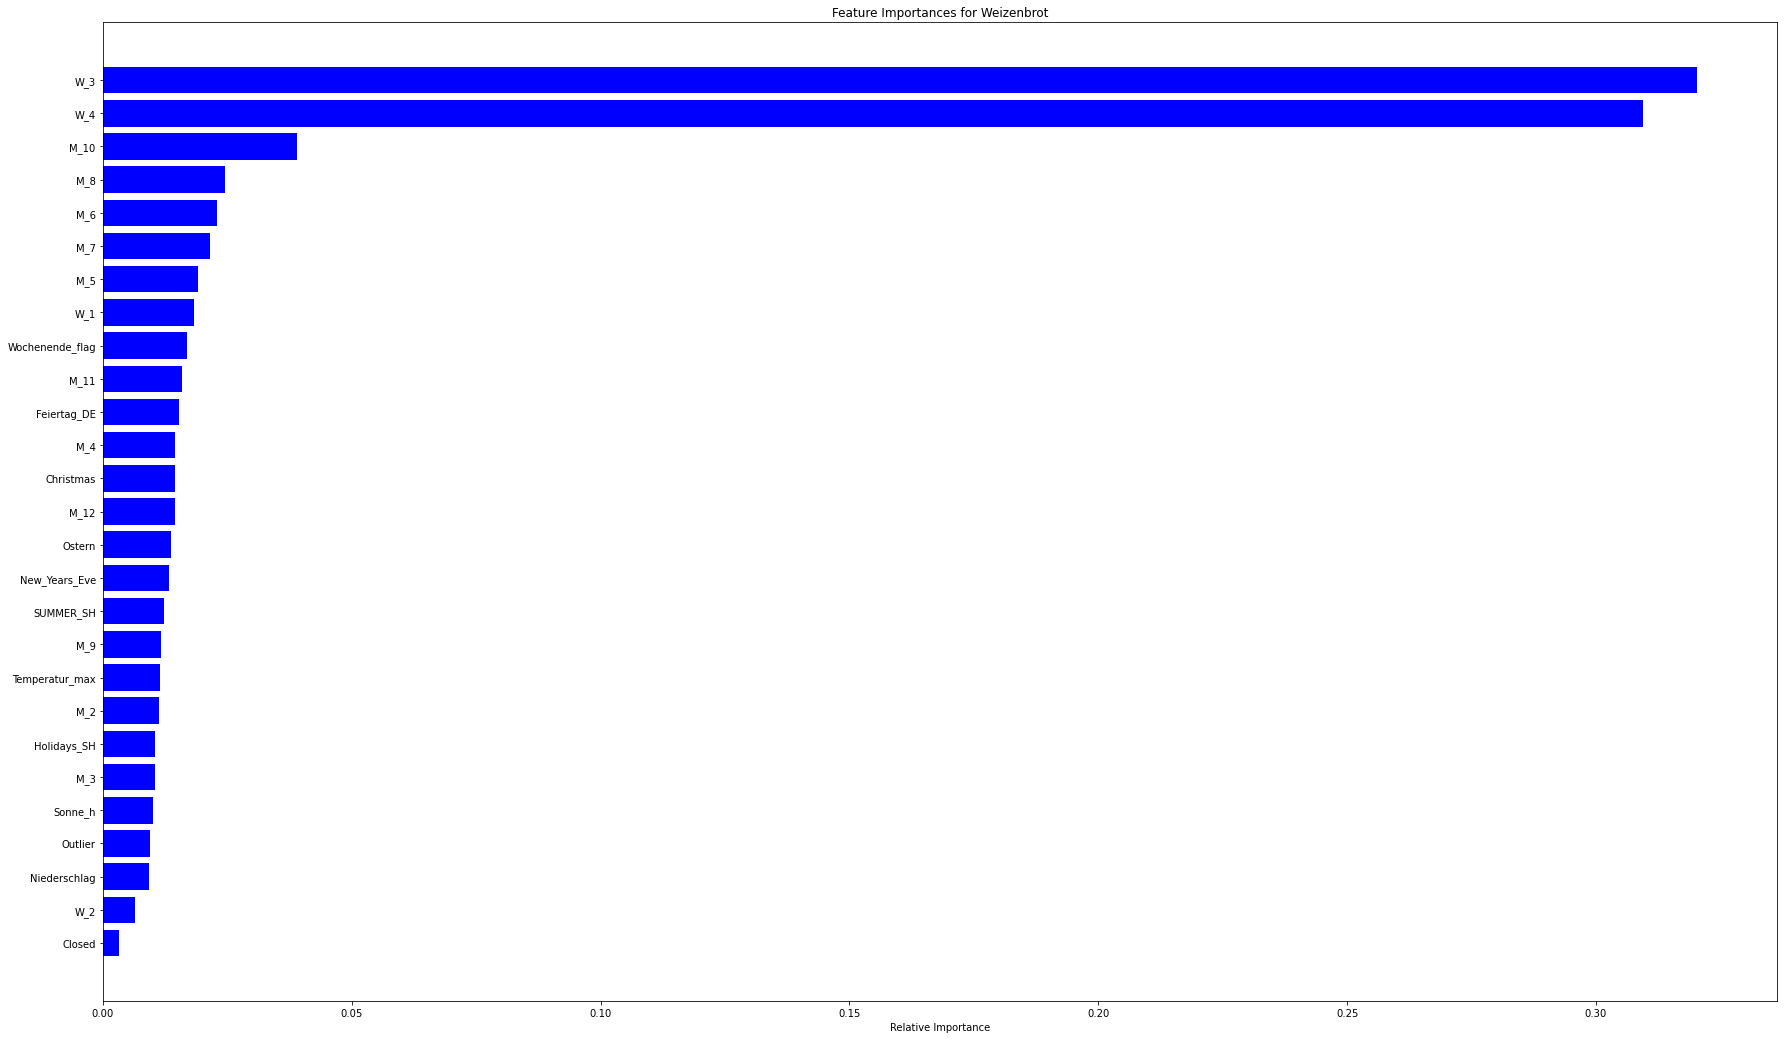

In [825]:
imp_2_1 = forest_1.feature_importances_
features = train_2.iloc[:,14:].columns
indices = np.argsort(imp_2_1)

plt.figure(figsize=(30,18))
plt.title('Feature Importances for Weizenbrot')
plt.barh(range(len(indices)), imp_2_1[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Mischbrot

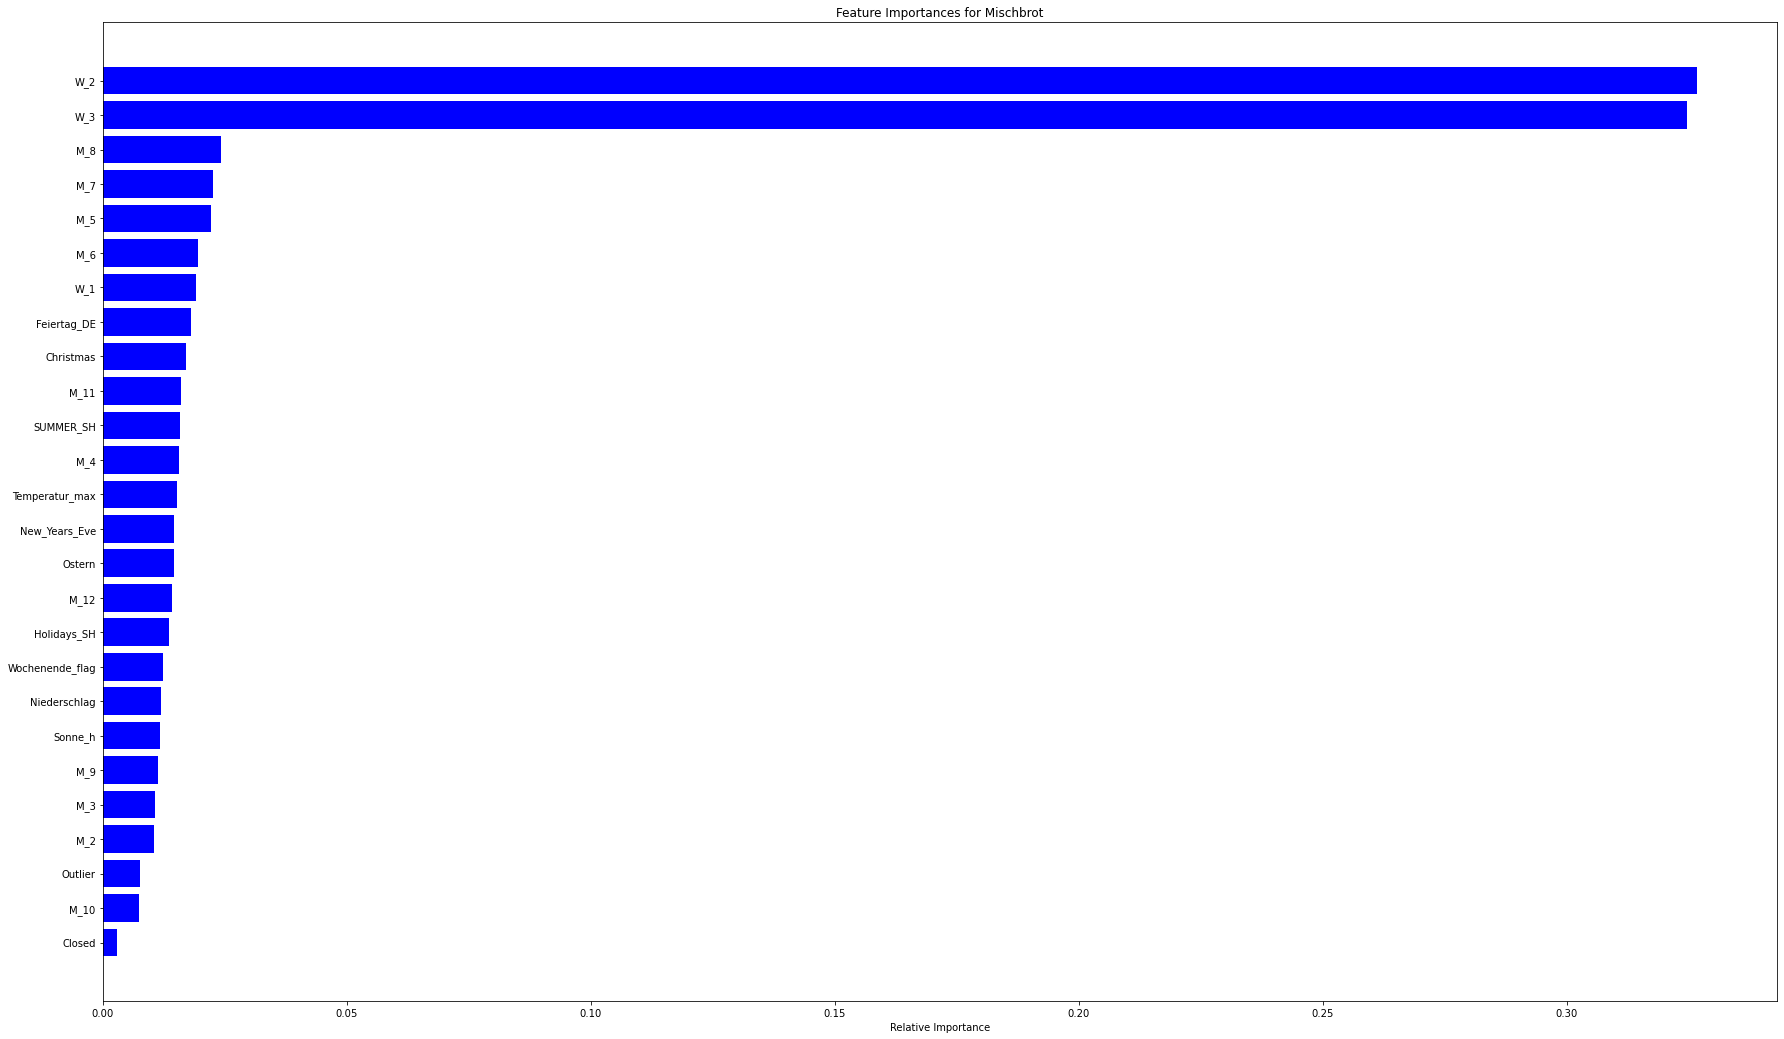

In [824]:
imp_2_2 = forest_2.feature_importances_
features = train_2.iloc[:,14:].columns
indices = np.argsort(imp_2_2)

plt.figure(figsize=(30,18))
plt.title('Feature Importances for Mischbrot')
plt.barh(range(len(indices)), imp_2_2[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Vollkornbrot

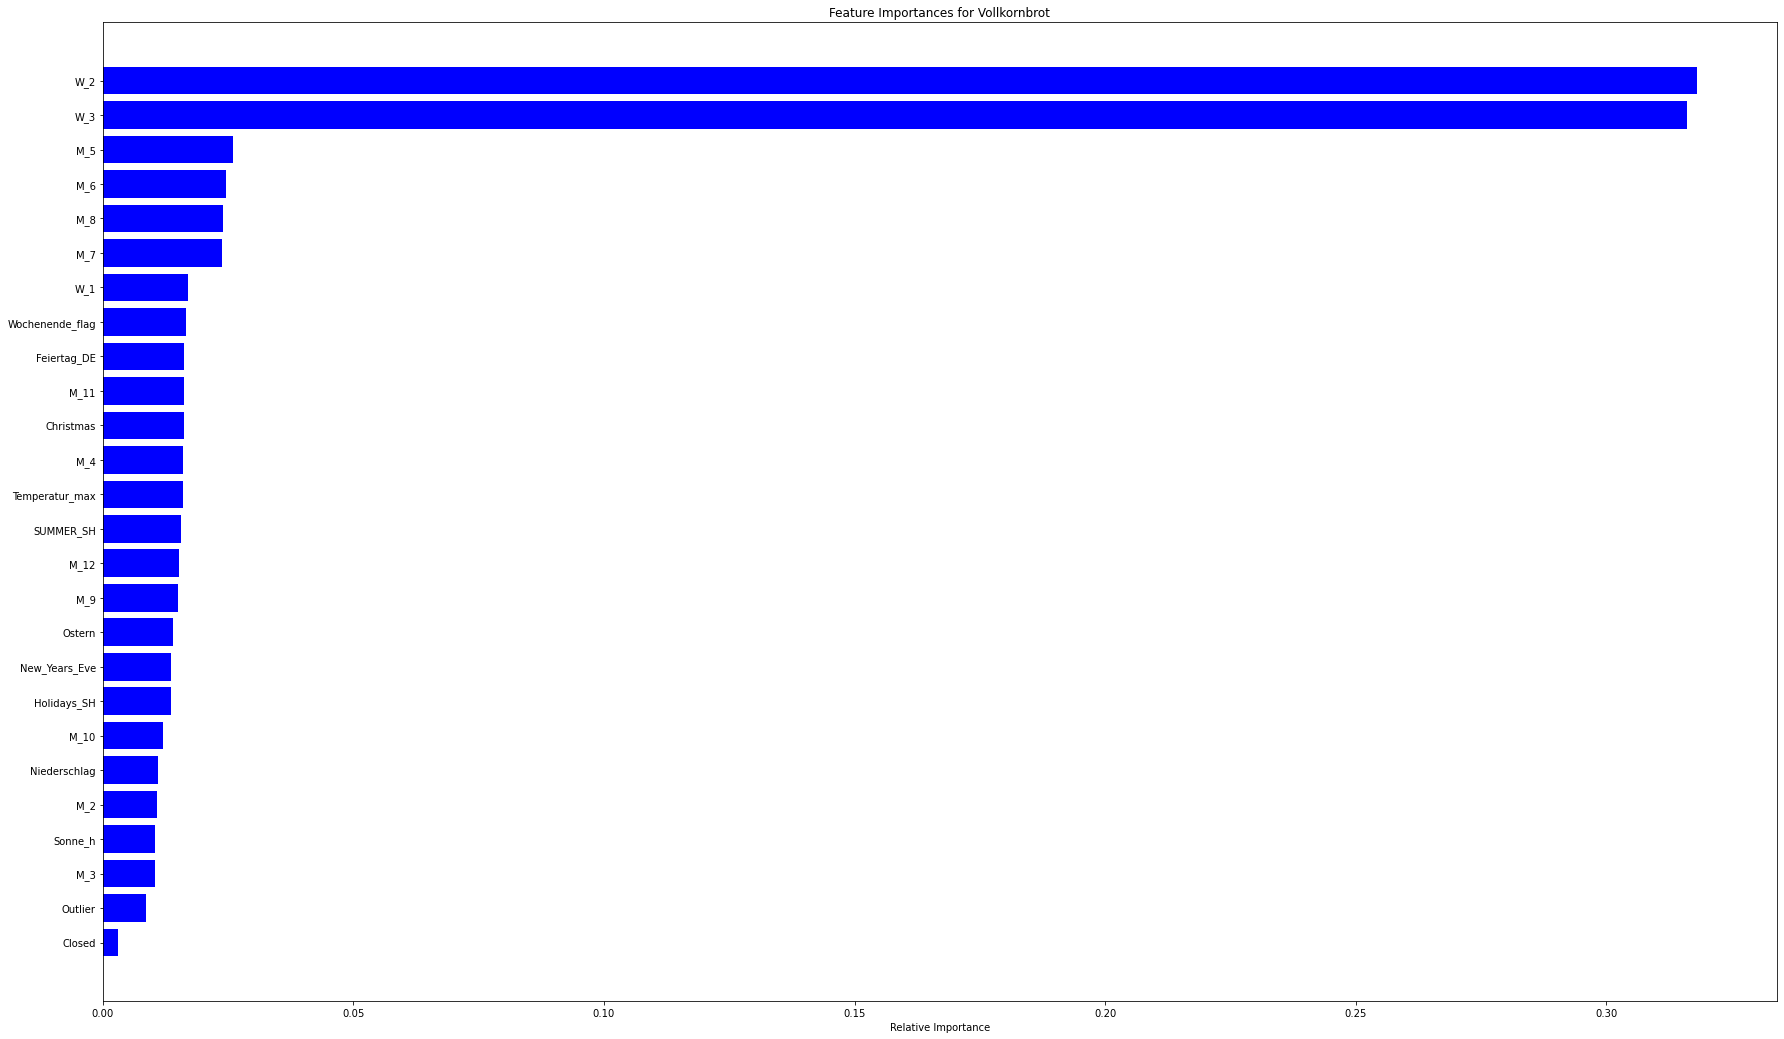

In [823]:
imp_2_3 = forest_3.feature_importances_
features = train_2.iloc[:,14:].columns
indices = np.argsort(imp_2_3)

plt.figure(figsize=(30,18))
plt.title('Feature Importances for Vollkornbrot')
plt.barh(range(len(indices)), imp_2_3[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Spezialbrot

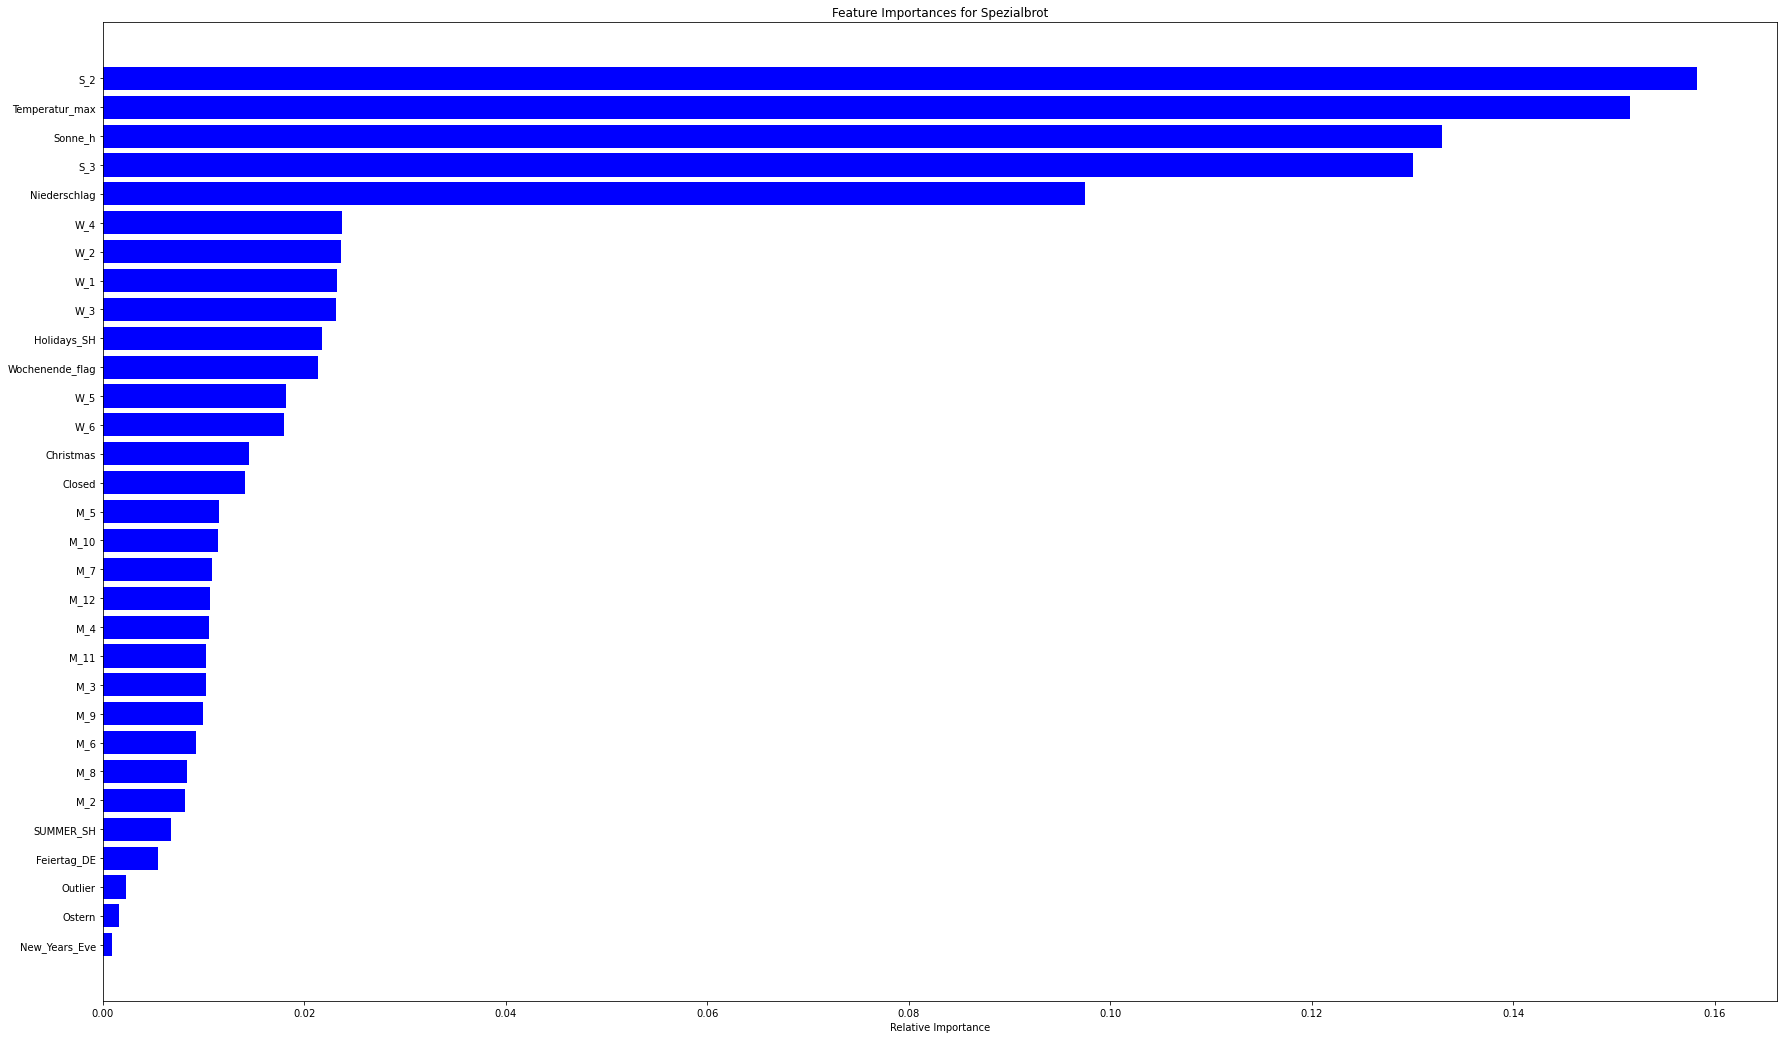

In [822]:
imp_2_4 = forest_4.feature_importances_
features = train_2.iloc[:,14:].columns
indices = np.argsort(imp_2_4)

plt.figure(figsize=(30,18))
plt.title('Feature Importances for Spezialbrot')
plt.barh(range(len(indices)), imp_2_4[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Stangenbrote

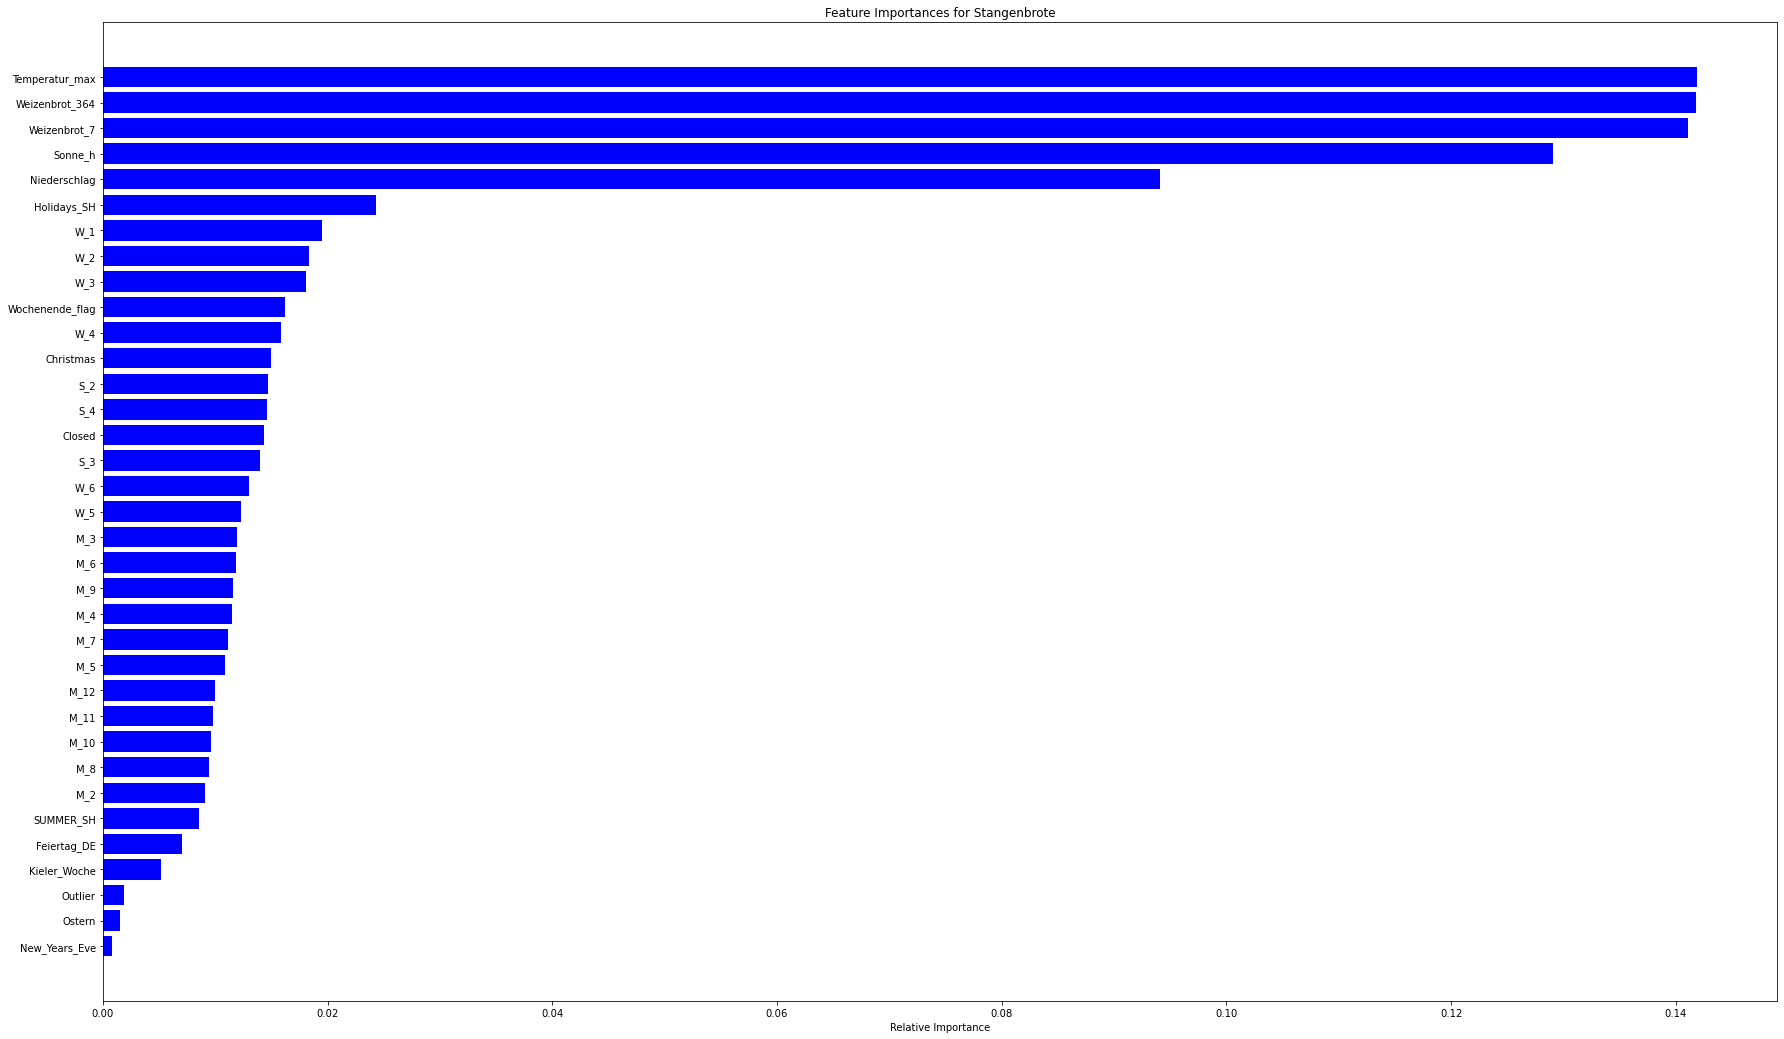

In [821]:
imp_2_5 = forest_5.feature_importances_
features = train_2.iloc[:,14:].columns
indices = np.argsort(imp_2_5)

plt.figure(figsize=(30,18))
plt.title('Feature Importances for Stangenbrote')
plt.barh(range(len(indices)), imp_2_5[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Brötchen

In [785]:
imp_2_6 = forest_6.feature_importances_
features = train_2.iloc[:,14:].columns
indices = np.argsort(imp_2_6)

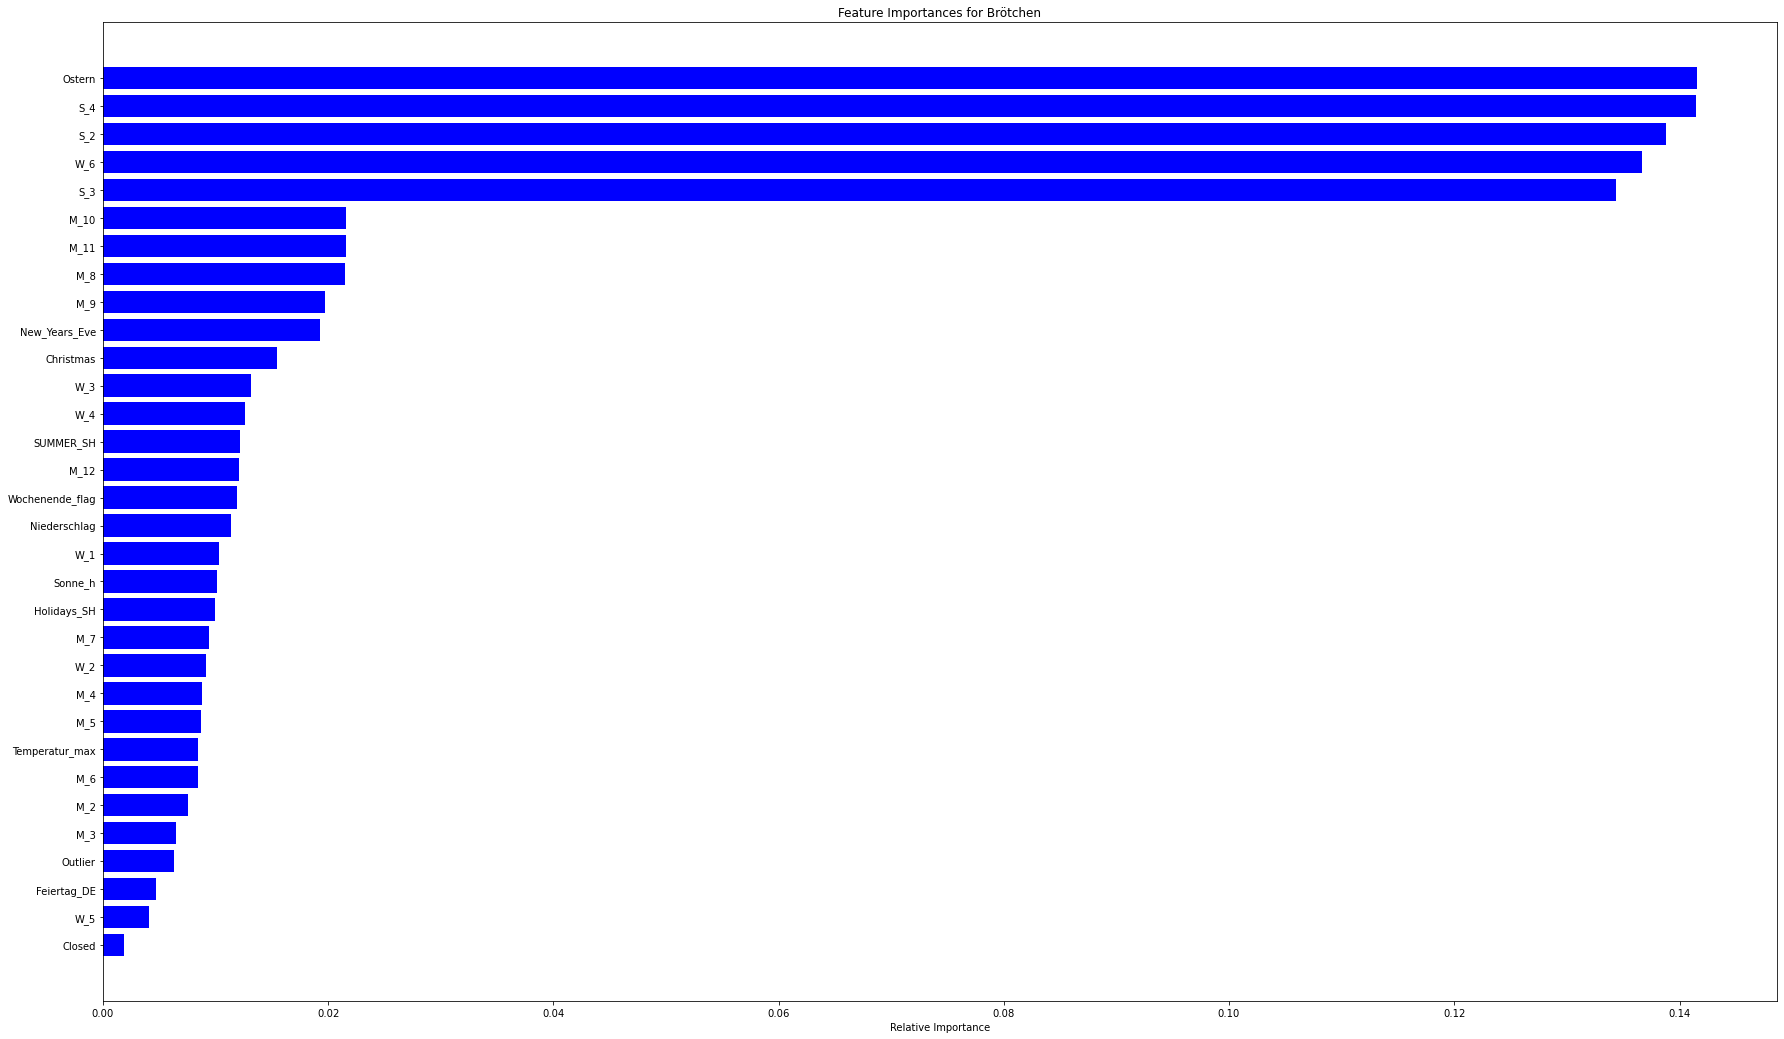

In [786]:
plt.figure(figsize=(30,18))
plt.title('Feature Importances for Brötchen')
plt.barh(range(len(indices)), imp_2_6[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Süsse Brötchen

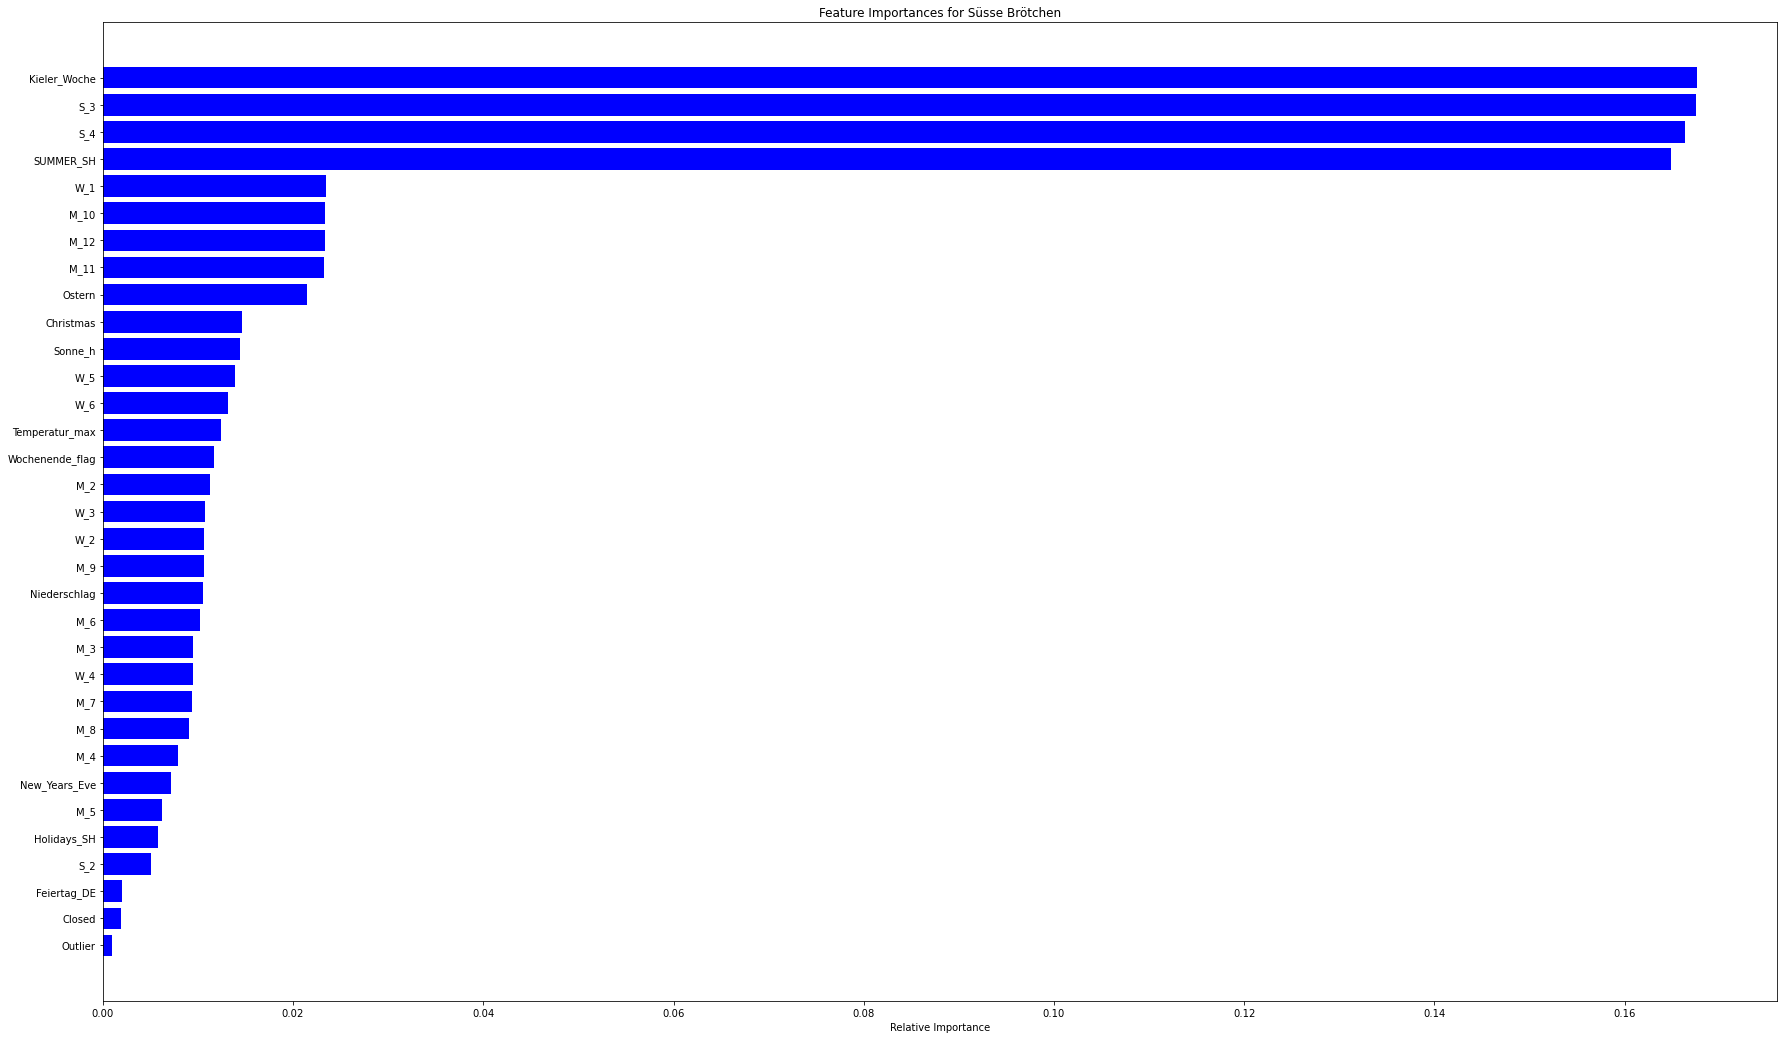

In [814]:
imp_2_7 = forest_7.feature_importances_
features = train_2.iloc[:,14:].columns
indices = np.argsort(imp_2_7)

plt.figure(figsize=(30,18))
plt.title('Feature Importances for Süsse Brötchen')
plt.barh(range(len(indices)), imp_2_7[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Herzhafte Brötchen

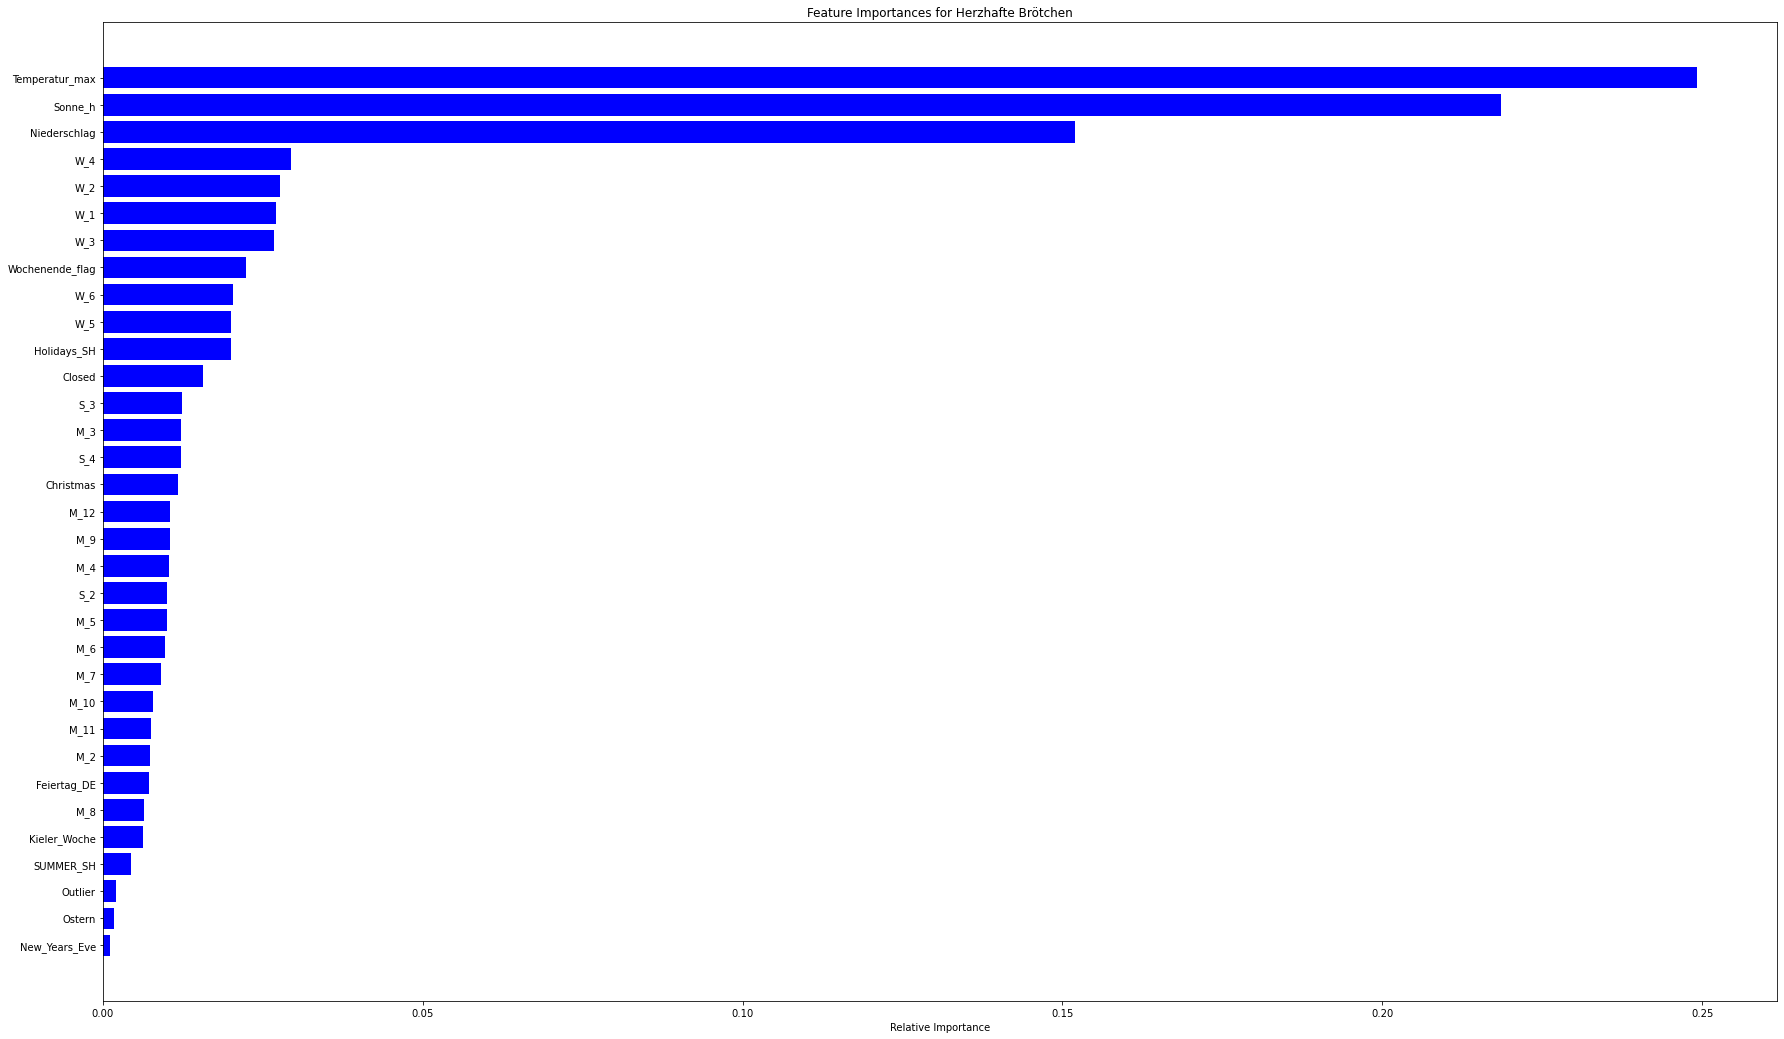

In [815]:
imp_2_8 = forest_8.feature_importances_
features = train_2.iloc[:,14:].columns
indices = np.argsort(imp_2_8)

plt.figure(figsize=(30,18))
plt.title('Feature Importances for Herzhafte Brötchen')
plt.barh(range(len(indices)), imp_2_8[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### KonditoreiBlech

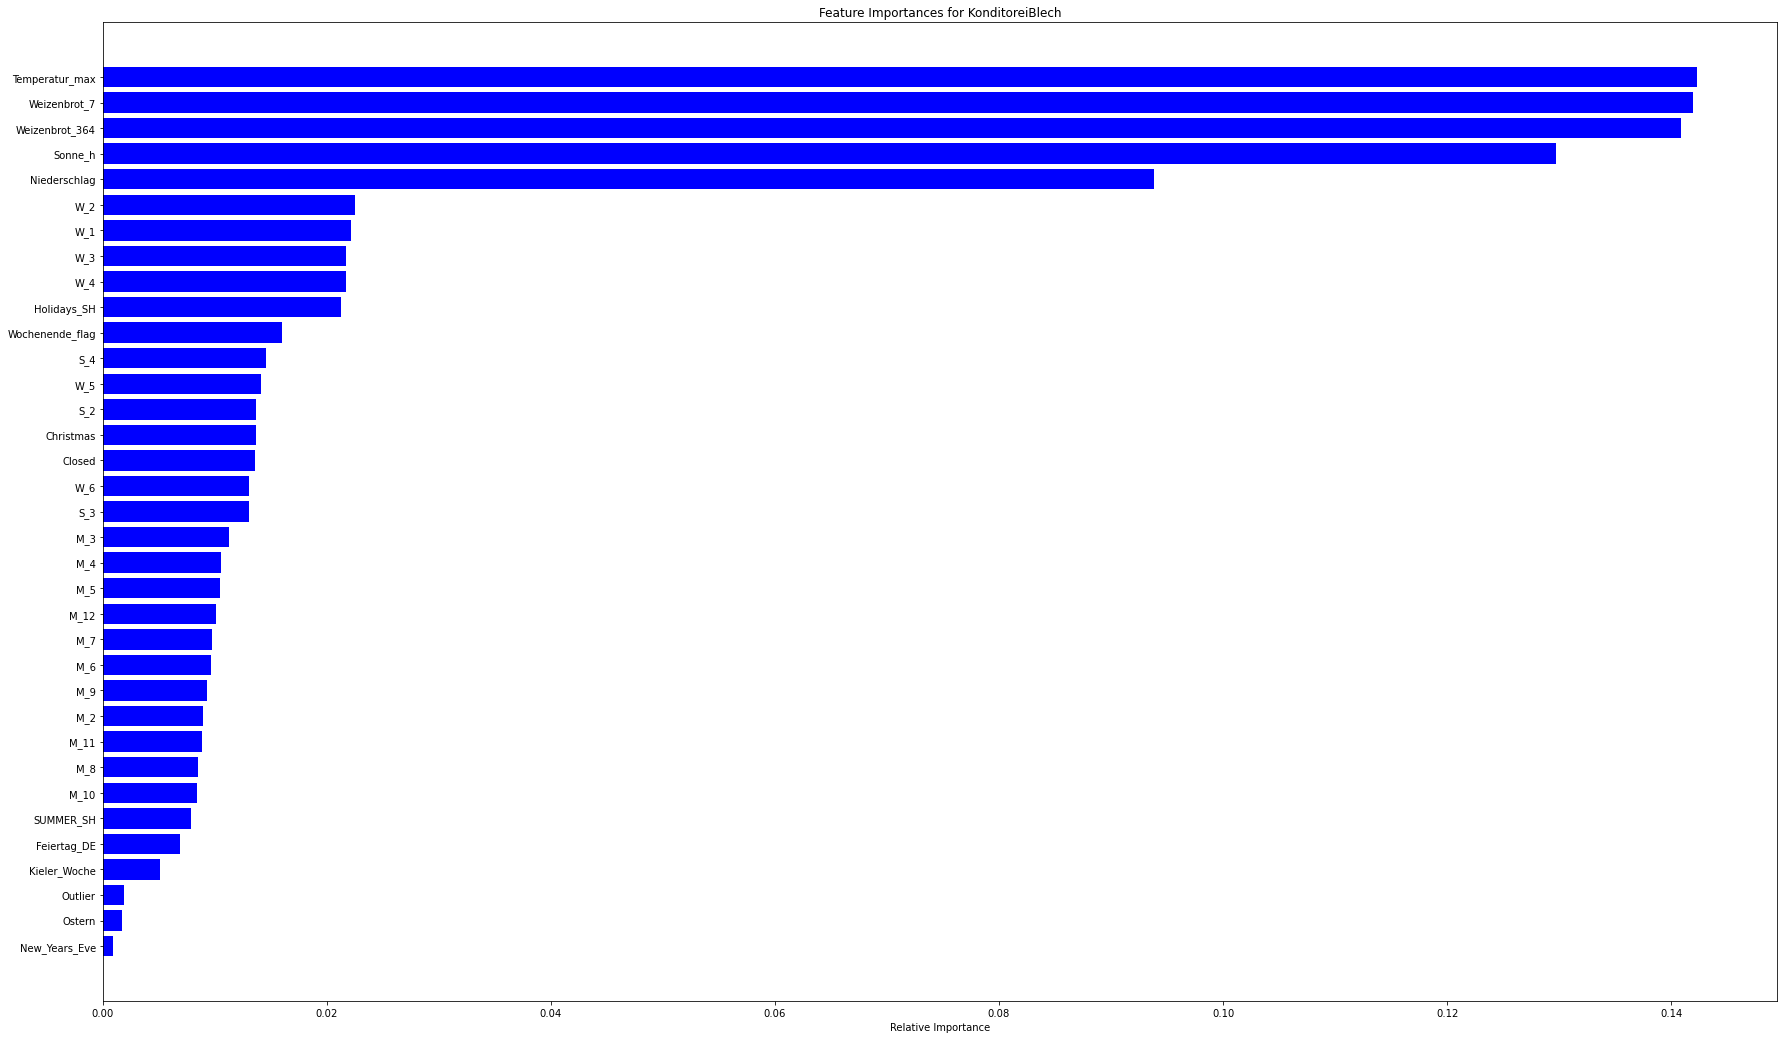

In [816]:
imp_2_9 = forest_9.feature_importances_
features = train_2.iloc[:,14:].columns
indices = np.argsort(imp_2_9)

plt.figure(figsize=(30,18))
plt.title('Feature Importances for KonditoreiBlech')
plt.barh(range(len(indices)), imp_2_9[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Stückgebäck

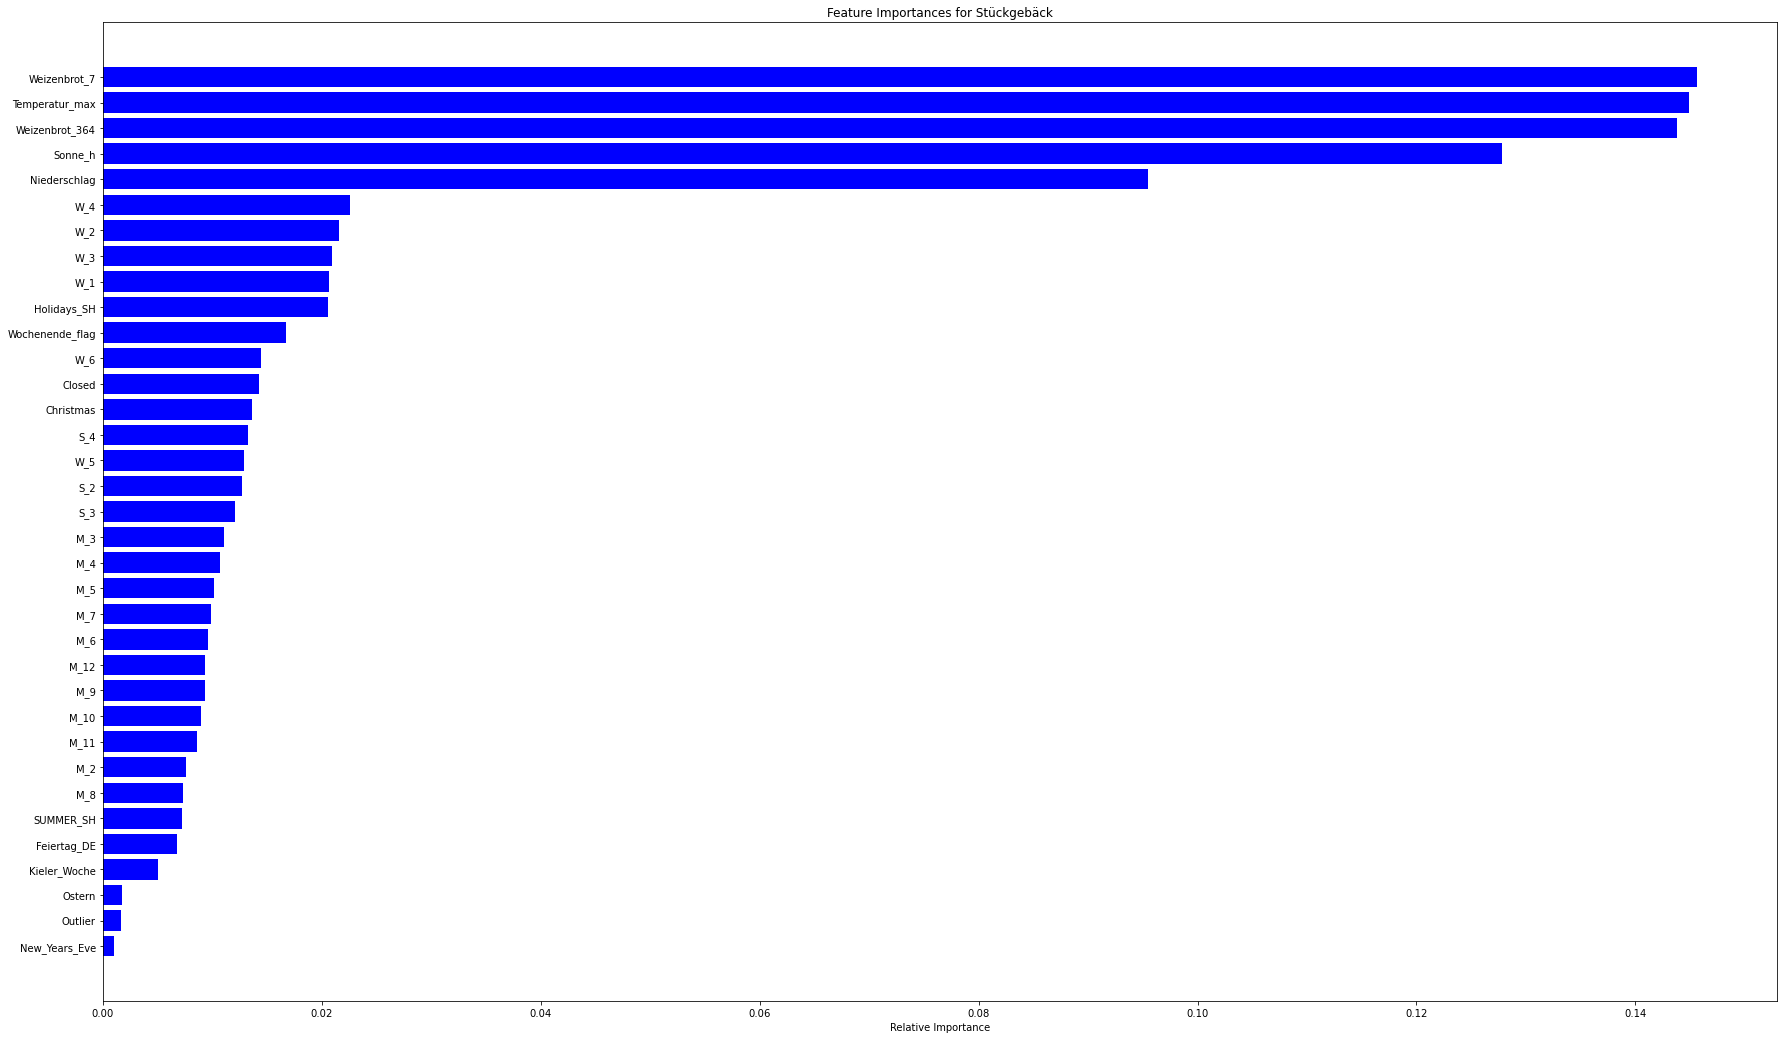

In [817]:
imp_2_10 = forest_10.feature_importances_
features = train_2.iloc[:,14:].columns
indices = np.argsort(imp_2_10)

plt.figure(figsize=(30,18))
plt.title('Feature Importances for Stückgebäck')
plt.barh(range(len(indices)), imp_2_10[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Blechkuchen

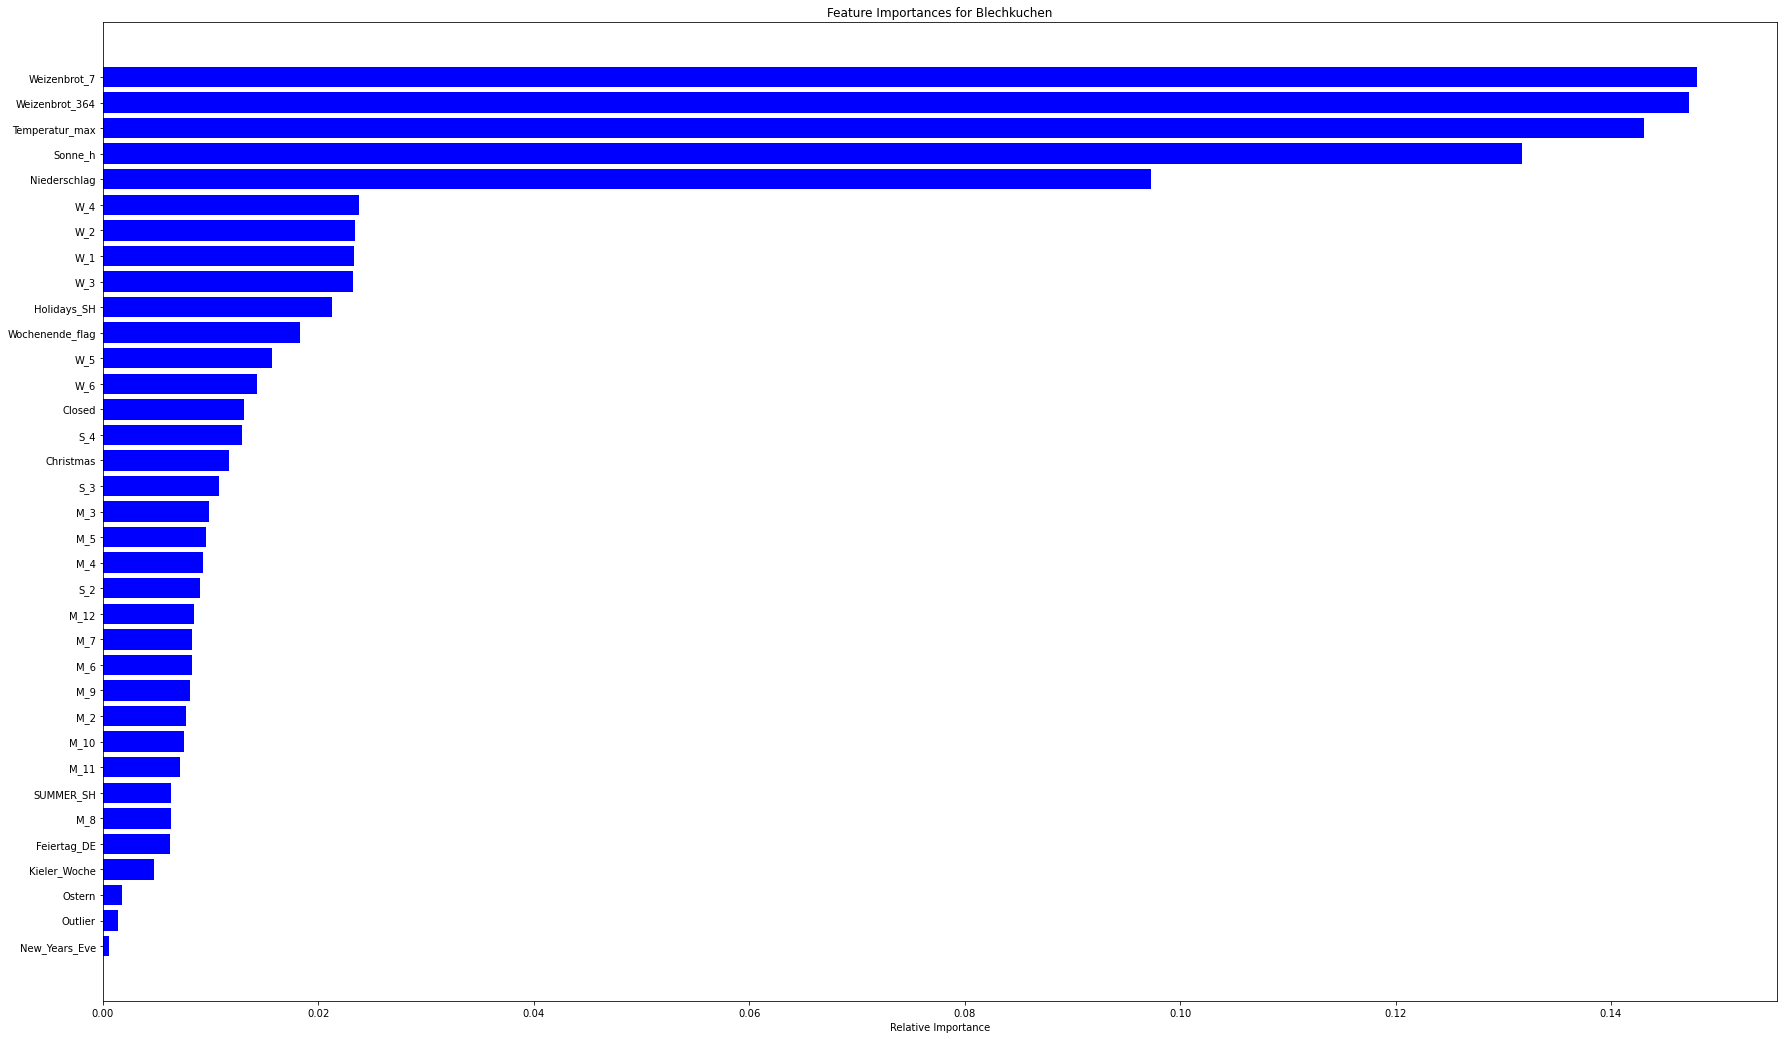

In [818]:
imp_2_11 = forest_11.feature_importances_
features = train_2.iloc[:,14:].columns
indices = np.argsort(imp_2_11)

plt.figure(figsize=(30,18))
plt.title('Feature Importances for Blechkuchen')
plt.barh(range(len(indices)), imp_2_11[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Weihnachtsartikel

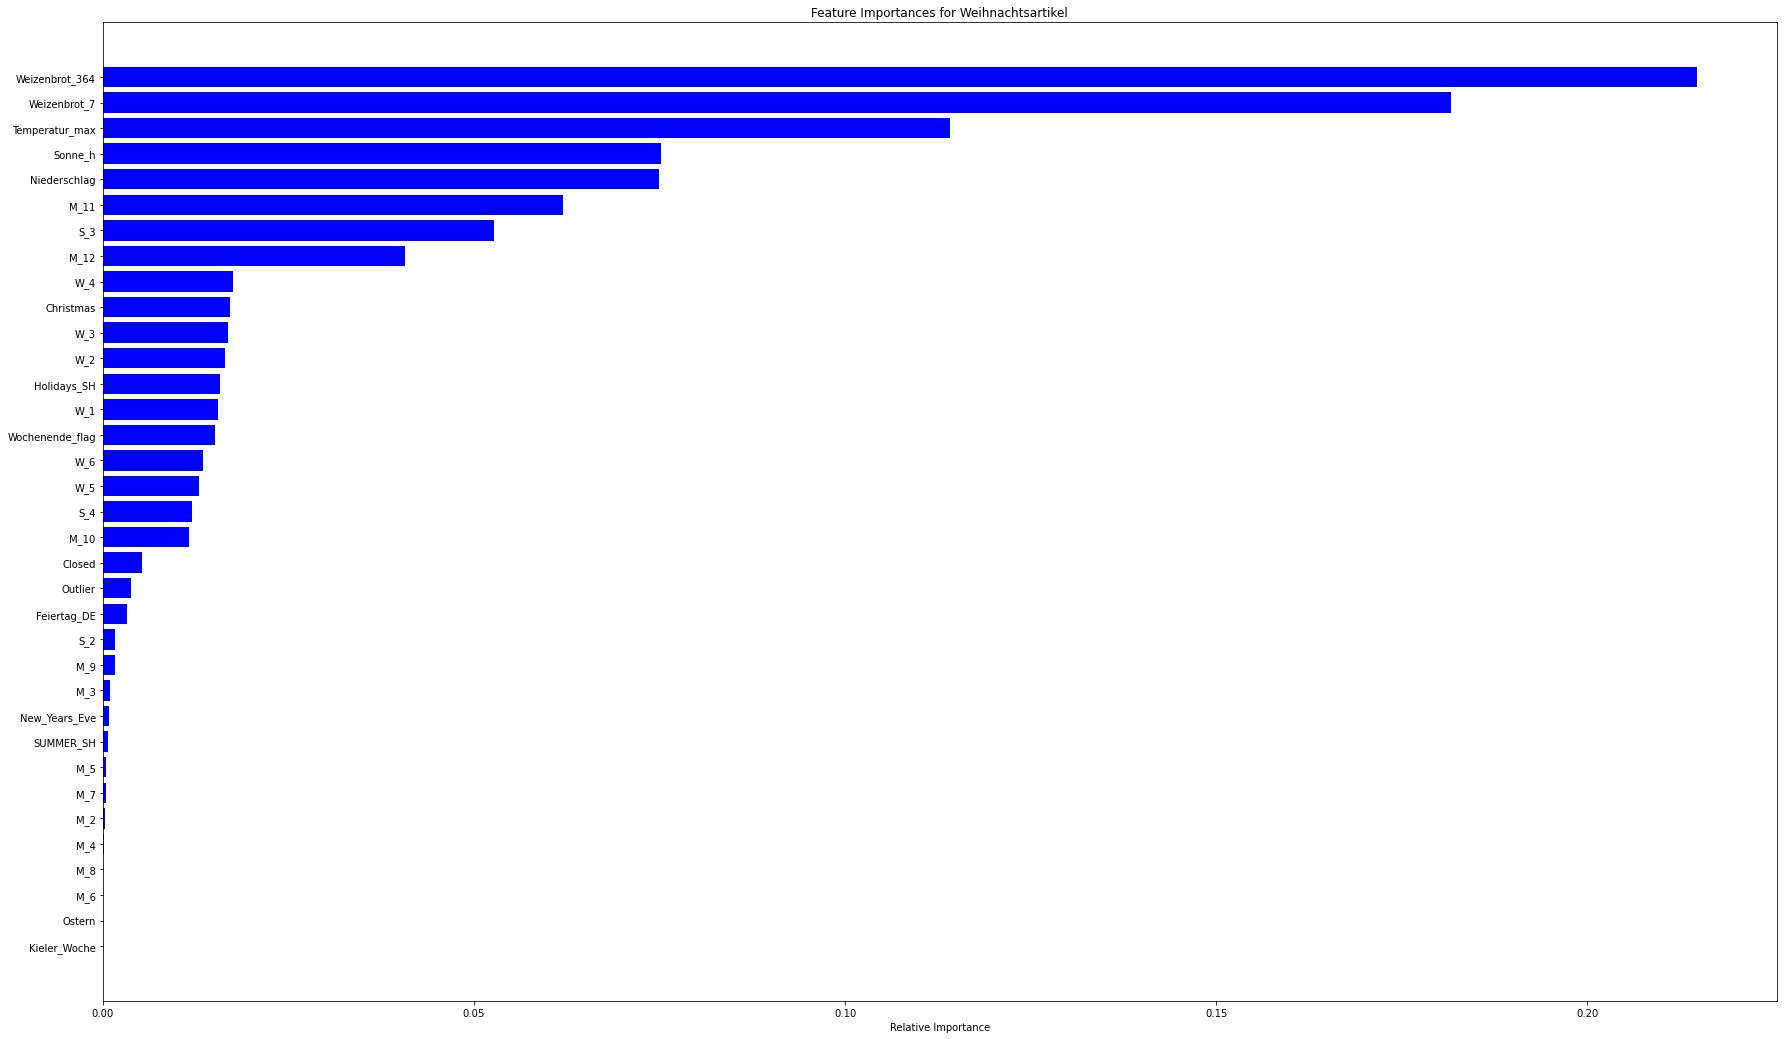

In [820]:
imp_2_12 = forest_12.feature_importances_
features = train_2.iloc[:,14:].columns
indices = np.argsort(imp_2_12)

plt.figure(figsize=(30,18))
plt.title('Feature Importances for Weihnachtsartikel')
plt.barh(range(len(indices)), imp_2_12[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Further optimazation due to performance plots

## More Models to consider?

### Time-Series Split

In [826]:
from sklearn.model_selection import TimeSeriesSplit

In [837]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor 
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

### Model Comparison for the total sales of the store

In [846]:
X_train=train_2.iloc[:,14:]
y_train=train_2['Gesamt']

NN: 0.073886 (0.296346)
KNN: 0.303330 (0.102435)
RF: 0.739576 (0.109346)
SVR: -0.122480 (0.131325)


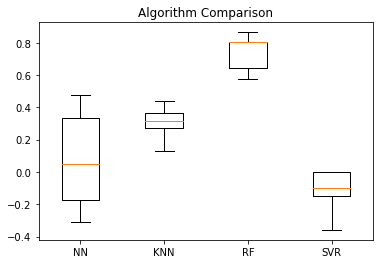

In [860]:
models = []
#models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
 tscv = TimeSeriesSplit(n_splits=5)
    
 cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

NN: 0.739053 (0.120304)
KNN: 0.567940 (0.129305)
RF: 0.801442 (0.010381)
SVR: -0.207726 (0.163659)


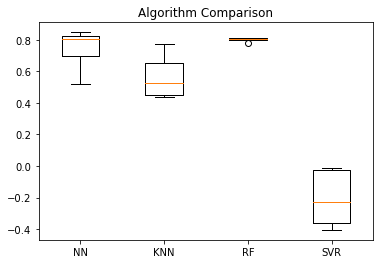

In [848]:
models = []
#models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
 tscv = TimeSeriesSplit(n_splits=5)
    
 cv_results = cross_val_score(model, X_train, train_2['Brötchen'], cv=tscv, scoring='r2')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

# Rocket

In [ ]:
X_train_R=train_2.iloc[:,14:].copy()

In [872]:
X_train_R

,Wochenende_flag,Christmas,Closed,Outlier,New_Years_Eve,Feiertag_DE,Ostern,Holidays_SH,SUMMER_SH,Niederschlag,...,KonditoreiBlech_364,Stückgebäck_7,Stückgebäck_364,Blechkuchen_7,Blechkuchen_364,Weihnachtsartikel_7,Weihnachtsartikel_364,Gesamt_7,Gesamt_364,BrötSüsse_Brötchen
365,0,1,1,0,0,1,0.0,1.0,0.0,0.0,...,66.333083,0.000000,249.331193,0.000000,36.972801,0.000000,113.343095,0.000000,919.067061,230
366,1,1,0,0,0,0,0.0,1.0,0.0,0.0,...,47.299856,0.000000,196.438985,0.000000,52.602766,0.000000,109.207363,0.000000,910.411262,230
367,1,1,0,0,0,0,0.0,1.0,0.0,0.0,...,193.858933,126.903870,231.631499,74.476714,108.559540,123.256931,124.089613,631.614164,855.706534,215
368,0,1,0,0,0,0,0.0,1.0,0.0,0.0,...,65.998678,192.494314,234.394777,0.000000,0.000000,117.004994,102.294044,801.344575,684.001282,166
369,0,1,0,0,0,0,0.0,1.0,0.0,0.0,...,59.165151,183.938934,178.318560,0.000000,44.629063,120.778548,99.925887,747.309626,617.677631,151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,0,1,0,0,0,0,0.0,1.0,0.0,0.0,...,63.687655,151.419355,188.032937,71.669457,58.941731,161.414000,0.000000,656.799833,740.645959,209
1457,0,1,0,0,0,0,0.0,1.0,0.0,1.6,...,68.511657,159.456816,228.223974,49.276745,0.000000,155.994870,0.000000,777.658460,811.323516,179
1458,1,1,0,0,0,0,0.0,1.0,0.0,6.1,...,85.151008,152.244660,420.581338,60.756020,29.090461,163.148575,0.000000,740.315226,939.043085,227
1459,1,1,0,1,0,0,0.0,1.0,0.0,0.0,...,40.254108,98.691672,1386.356115,65.125747,47.570151,128.217445,0.000000,618.018431,997.690947,242


In [868]:
y_train=train_2['Brötchen']

In [869]:
import numpy as np
from sklearn.linear_model import RidgeClassifierCV

In [870]:
#from sktime.datasets import load_arrow_head  # univariate dataset
from sktime.transformers.series_as_features.rocket import Rocket

In [871]:
rocket = Rocket(num_kernels=10000, random_state=111) 
rocket.fit(X_train_R)
X_train_transform = rocket.transform(X_train_R)
X_train_transform.shape

ValueError: If passed as a pd.DataFrame, X must be a nested pd.DataFrame, with pd.Series or np.arrays inside cells.

In [ ]:
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier.fit(X_train_transform, y_train)

In [ ]:
X_test_transform = rocket.transform(X_test)
classifier.score(X_test_transform, y_test)